# Install and Set up

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [2]:
# import sys
# sys.path.append('/content/gdrive/MyDrive/PrimeVisionProj')

In [3]:
# %cd /content/gdrive/MyDrive/PrimeVisionProj
# !ls

In [4]:
# !pip install rl4co==0.3.3
# !pip install torch==2.3.0
# !pip install matplotlib

# Build Model and test untrained model

In [5]:
from SPPembeddings import SPPInitEmbedding, SPPContext, StaticEmbedding
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy, POMO, POMOPolicy
from SPPenv import SPPEnv
from FPenv import FPEnv

# env = SPPEnv(num_loc=100)
env = FPEnv(fp_path="Floorplans/quad-infeed/butterfly/14x11/floorplan.json")

# from SPPv2env import SPPv2Env
# env = SPPv2Env(num_loc=100)

# Instantiate policy with the embeddings we created above
emb_dim = 64
# policy = AutoregressivePolicy(env,
#                               embedding_dim=emb_dim,
#                               init_embedding=SPPInitEmbedding(emb_dim),
#                               context_embedding=SPPContext(emb_dim),
#                               dynamic_embedding=StaticEmbedding(emb_dim),
#                               train_decode_type="multistart_greedy",
#                               val_decode_type="greedy",
#                               test_decode_type="greedy",
#                               num_starts=2
# )

policy = POMOPolicy(env,
                    embedding_dim=emb_dim,
                    init_embedding=SPPInitEmbedding(emb_dim),
                    context_embedding=SPPContext(emb_dim),
                    dynamic_embedding=StaticEmbedding(emb_dim),
                    train_decode_type="greedy",
                    val_decode_type="greedy",
                    test_decode_type="greedy"
                    )

# model = POMO(env, policy=policy,
#                   baseline='shared',
#                   batch_size=3,
#                   train_data_size=100,
#                   val_data_size=100,)

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       policy=policy,
                       baseline='rollout',
                       train_data_size=100_00,
                       val_data_size=100_0,
                       batch_size=4,
                       val_batch_size=4,
                       test_batch_size=4)

/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


batch_size in reset: [4]


reward:  tensor([   40., -9950., -9950., -9950.], device='cuda:0')
Problem 1 | Cost: -40.000


/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Problem 2 | Cost: 9950.000


Problem 3 | Cost: 9950.000


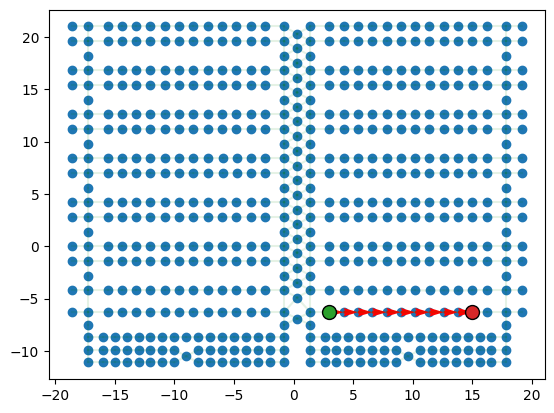

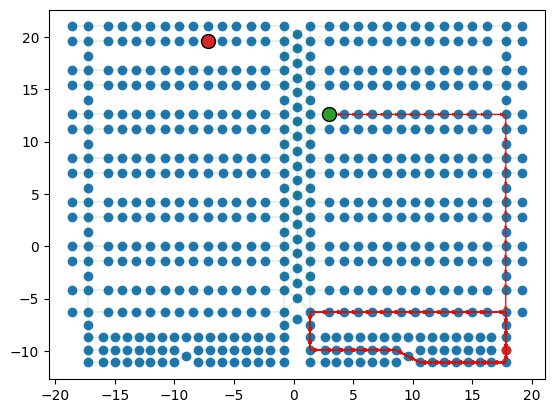

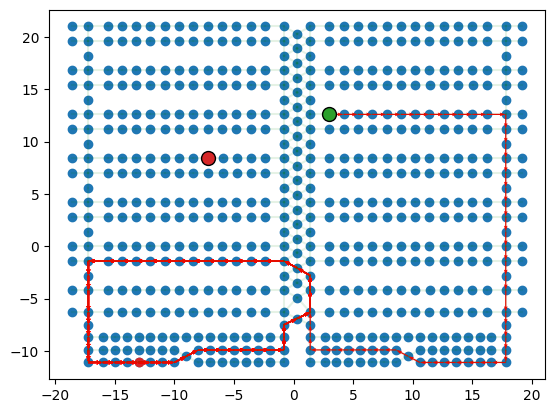

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[4]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

# Train model

In [7]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    logger=None
)

trainer.fit(model)

# Save the model
torch.save(model, 'Models/TrainOnFloorplansResults8.pth')

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
val_file not set. Generating dataset instead


test_file not set. Generating dataset instead


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name     | Type           | Params
--------------------------------------------
0 | env      | FPEnv          | 0     
1 | policy   | POMOPolicy     | 527 K 
2 | baseline | WarmupBaseline | 527 K 
--------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.217     Total estimated model params size (MB)


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Sanity Checking: |                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]

Sanity Checking:   0%|                                                                                                                                                                                       | 0/1 [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|                                                                                                                                                                          | 0/1 [00:00<?, ?it/s]

/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]

/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                                                                                                                  | 0/? [00:00<?, ?it/s]

Training:   0%|                                                                                                                                                                                              | 0/1 [00:00<?, ?it/s]

Epoch 0:   0%|                                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.80it/s]

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.80it/s, v_num=22, train/reward=-9950.0, train/loss=0.000]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.54it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.54it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950.,    42., -9950.], device='cuda:0')
Epoch 0:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 1:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=-1.76e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-1.76e+5, val/reward=-9950.0]

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-1.76e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 1:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.76e+5, val/reward=-9950.0]

Epoch 2:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.76e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950.,    21., -9950.], device='cuda:0')


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-9950.0, train/loss=-1.76e+5, val/reward=-9950.0]

Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-7457.25, train/loss=2.1e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9.9500e+03, -9.9500e+03,  9.0000e+00, -9.9500e+03], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=22, train/reward=-7457.25, train/loss=2.1e+5, val/reward=-7460.25]

Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=22, train/reward=-7457.25, train/loss=2.1e+5, val/reward=-7460.25]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 2:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7457.25, train/loss=2.1e+5, val/reward=-7460.25]

Epoch 3:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7457.25, train/loss=2.1e+5, val/reward=-7460.25]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7457.25, train/loss=2.1e+5, val/reward=-7460.25]

Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7460.25]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-8.0000e+00, -9.9500e+03, -9.9500e+03, -9.9500e+03], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7464.5]

Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7464.5]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 3:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7464.5]

Epoch 4:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7464.5]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7464.5]

Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7464.5]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950.,   -28.], device='cuda:0')


reward:  tensor([  -48., -9950., -9950., -9950.], device='cuda:0')
Epoch 4:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 5:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=-1.8e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-1.8e+5, val/reward=-9950.0]

Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-1.8e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950.,    14., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 5:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.8e+5, val/reward=-9950.0]

Epoch 6:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.8e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=-1.8e+5, val/reward=-9950.0]

Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]

Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.66it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 6:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 7:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9.9500e+03, -9.9500e+03, -9.9500e+03, -8.0000e+00], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 7:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 8:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950.,   -34., -9950.], device='cuda:0')


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.93it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.92it/s, v_num=22, train/reward=-7471.0, train/loss=1.97e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.60it/s, v_num=22, train/reward=-7471.0, train/loss=1.97e+5, val/reward=-9950.0]

Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.60it/s, v_num=22, train/reward=-7471.0, train/loss=1.97e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9.9500e+03, -9.9500e+03, -9.9500e+03, -3.0000e+00], device='cuda:0')
Epoch 8:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7471.0, train/loss=1.97e+5, val/reward=-9950.0]

Epoch 9:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7471.0, train/loss=1.97e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7471.0, train/loss=1.97e+5, val/reward=-9950.0]

Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=-2.28e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-2.28e+5, val/reward=-9950.0]

Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-2.28e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 9:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-2.28e+5, val/reward=-9950.0]

Epoch 10:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-2.28e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950.,    34.], device='cuda:0')


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-9950.0, train/loss=-2.28e+5, val/reward=-9950.0]

Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-7454.0, train/loss=1.28e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7454.0, train/loss=1.28e+5, val/reward=-9950.0]

Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7454.0, train/loss=1.28e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 10:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7454.0, train/loss=1.28e+5, val/reward=-9950.0]

Epoch 11:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7454.0, train/loss=1.28e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7454.0, train/loss=1.28e+5, val/reward=-9950.0]

Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 11:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 12:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]

Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 12:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 13:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 13:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 14:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]

Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 14:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 15:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950.,    39., -9950.,    30.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4957.75]

Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4957.75]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 15:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4957.75]

Epoch 16:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4957.75]

reward:  tensor([  -37., -9950., -9950., -9950.], device='cuda:0')


Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.92it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4957.75]

Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.92it/s, v_num=22, train/reward=-7471.75, train/loss=1.75e+5, val/reward=-4957.75]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.60it/s, v_num=22, train/reward=-7471.75, train/loss=1.75e+5, val/reward=-9950.0]

Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.60it/s, v_num=22, train/reward=-7471.75, train/loss=1.75e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 16:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7471.75, train/loss=1.75e+5, val/reward=-9950.0]

Epoch 17:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7471.75, train/loss=1.75e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950.,   -10.], device='cuda:0')


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7471.75, train/loss=1.75e+5, val/reward=-9950.0]

Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7465.0, train/loss=2.44e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7465.0, train/loss=2.44e+5, val/reward=-9950.0]

Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7465.0, train/loss=2.44e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 17:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7465.0, train/loss=2.44e+5, val/reward=-9950.0]

Epoch 18:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7465.0, train/loss=2.44e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-7465.0, train/loss=2.44e+5, val/reward=-9950.0]

Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 18:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 19:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950.,   -28.], device='cuda:0')


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-7469.5, train/loss=2.31e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7469.5, train/loss=2.31e+5, val/reward=-9950.0]

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7469.5, train/loss=2.31e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950.,    35.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 19:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7469.5, train/loss=2.31e+5, val/reward=-9950.0]

Epoch 20:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7469.5, train/loss=2.31e+5, val/reward=-9950.0]

reward:  tensor([-9950.,   -12., -9950.,   -38.], device='cuda:0')


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7469.5, train/loss=2.31e+5, val/reward=-9950.0]

Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-4987.5, train/loss=4.53e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]

Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-4987.5, train/loss=4.53e+5, val/reward=-9950.0]

Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-4987.5, train/loss=4.53e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 20:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4987.5, train/loss=4.53e+5, val/reward=-9950.0]

Epoch 21:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4987.5, train/loss=4.53e+5, val/reward=-9950.0]

reward:  tensor([-9950.,    47., -9950., -9950.], device='cuda:0')


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-4987.5, train/loss=4.53e+5, val/reward=-9950.0]

Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7450.75, train/loss=2.18e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7450.75, train/loss=2.18e+5, val/reward=-9950.0]

Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7450.75, train/loss=2.18e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950.,   -10., -9950.], device='cuda:0')
Epoch 21:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7450.75, train/loss=2.18e+5, val/reward=-9950.0]

Epoch 22:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7450.75, train/loss=2.18e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7450.75, train/loss=2.18e+5, val/reward=-9950.0]

Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=-3.97e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-3.97e+5, val/reward=-9950.0]

Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-3.97e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 22:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-3.97e+5, val/reward=-9950.0]

Epoch 23:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-3.97e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=-3.97e+5, val/reward=-9950.0]

Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 23:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 24:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.93it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.93it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.60it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.60it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9.9500e+03, -2.0000e+00, -9.9500e+03, -9.9500e+03], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 24:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 25:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([   10., -9950., -9950., -9950.], device='cuda:0')


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7460.0, train/loss=1.89e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]

Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7460.0, train/loss=1.89e+5, val/reward=-9950.0]

Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7460.0, train/loss=1.89e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950.,    49.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950.,    27.], device='cuda:0')
Epoch 25:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7460.0, train/loss=1.89e+5, val/reward=-9950.0]

Epoch 26:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7460.0, train/loss=1.89e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-7460.0, train/loss=1.89e+5, val/reward=-9950.0]

Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-9950.0, train/loss=-1.74e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-1.74e+5, val/reward=-9950.0]

Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-1.74e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950.,   -41., -9950., -9950.], device='cuda:0')
Epoch 26:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.74e+5, val/reward=-9950.0]

Epoch 27:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.74e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950.,    47.], device='cuda:0')


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=-1.74e+5, val/reward=-9950.0]

Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7450.75, train/loss=-1.7e+4, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]

Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7450.75, train/loss=-1.7e+4, val/reward=-9950.0]

Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7450.75, train/loss=-1.7e+4, val/reward=-9950.0]

reward:  tensor([-9950.,    39., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 27:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7450.75, train/loss=-1.7e+4, val/reward=-9950.0]

Epoch 28:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7450.75, train/loss=-1.7e+4, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7450.75, train/loss=-1.7e+4, val/reward=-9950.0]

Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950.,    48.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7450.5]

Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7450.5]

reward:  tensor([-9950., -9950., -9950.,   -12.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950.,    39.], device='cuda:0')
Epoch 28:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7450.5]

Epoch 29:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7450.5]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7450.5]

Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=-5.17e+5, val/reward=-7450.5]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-5.17e+5, val/reward=-9950.0]

Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-5.17e+5, val/reward=-9950.0]

reward:  tensor([-7.0000e+00, -9.9500e+03, -9.9500e+03, -9.9500e+03], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 29:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-5.17e+5, val/reward=-9950.0]

Epoch 30:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-5.17e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.94it/s, v_num=22, train/reward=-9950.0, train/loss=-5.17e+5, val/reward=-9950.0]

Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.94it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.60it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.60it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9.9500e+03, -9.9500e+03, -8.0000e+00, -9.9500e+03], device='cuda:0')
Epoch 30:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 31:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 31: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=-2.26e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950.,    41., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-2.26e+5, val/reward=-7452.25]

Epoch 31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-2.26e+5, val/reward=-7452.25]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 31:   0%|                                                                                                                    | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-2.26e+5, val/reward=-7452.25]

Epoch 32:   0%|                                                                                                                    | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-2.26e+5, val/reward=-7452.25]

reward:  tensor([   28., -9950., -9950., -9950.], device='cuda:0')


Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=-2.26e+5, val/reward=-7452.25]

Epoch 32: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7455.5, train/loss=2.53e+5, val/reward=-7452.25]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7455.5, train/loss=2.53e+5, val/reward=-9950.0]

Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7455.5, train/loss=2.53e+5, val/reward=-9950.0]

reward:  tensor([-6.0000e+00, -9.9500e+03, -9.9500e+03, -9.9500e+03], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 32:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7455.5, train/loss=2.53e+5, val/reward=-9950.0]

Epoch 33:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7455.5, train/loss=2.53e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950.,    49., -9950.], device='cuda:0')


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7455.5, train/loss=2.53e+5, val/reward=-9950.0]

Epoch 33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7450.25, train/loss=2.19e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950.,    27., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]

Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7450.25, train/loss=2.19e+5, val/reward=-7455.75]

Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7450.25, train/loss=2.19e+5, val/reward=-7455.75]

reward:  tensor([-9950., -9950., -9950.,    16.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 33:   0%|                                                                                                                    | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7450.25, train/loss=2.19e+5, val/reward=-7455.75]

Epoch 34:   0%|                                                                                                                    | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7450.25, train/loss=2.19e+5, val/reward=-7455.75]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7450.25, train/loss=2.19e+5, val/reward=-7455.75]

Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7455.75]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]

Epoch 34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950.,    45.], device='cuda:0')


reward:  tensor([-1.0000e+00, -9.9500e+03, -9.9500e+03, -9.9500e+03], device='cuda:0')
Epoch 34:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 35:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-9950.0, train/loss=-1.68e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9.9500e+03, -9.9500e+03, -9.9500e+03,  4.0000e+00], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=22, train/reward=-9950.0, train/loss=-1.68e+5, val/reward=-7461.5]

Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=22, train/reward=-9950.0, train/loss=-1.68e+5, val/reward=-7461.5]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 35:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.68e+5, val/reward=-7461.5]

Epoch 36:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.68e+5, val/reward=-7461.5]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 36: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=-1.68e+5, val/reward=-7461.5]

Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7461.5]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([   47., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7450.75]

Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7450.75]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 36:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7450.75]

Epoch 37:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7450.75]

reward:  tensor([-9.9500e+03, -9.9500e+03, -9.9500e+03,  4.0000e+00], device='cuda:0')


Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.92it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7450.75]

Epoch 37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.92it/s, v_num=22, train/reward=-7461.5, train/loss=1.12e+5, val/reward=-7450.75]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.60it/s, v_num=22, train/reward=-7461.5, train/loss=1.12e+5, val/reward=-9950.0]

Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.60it/s, v_num=22, train/reward=-7461.5, train/loss=1.12e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 37:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7461.5, train/loss=1.12e+5, val/reward=-9950.0]

Epoch 38:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7461.5, train/loss=1.12e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7461.5, train/loss=1.12e+5, val/reward=-9950.0]

Epoch 38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]

Epoch 38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 38:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 39:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9.9500e+03,  6.0000e+00, -9.9500e+03, -9.9500e+03], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 39:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 40:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([   39., -9950., -9950., -9950.], device='cuda:0')


Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7452.75, train/loss=1.93e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]

Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.66it/s, v_num=22, train/reward=-7452.75, train/loss=1.93e+5, val/reward=-9950.0]

Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.66it/s, v_num=22, train/reward=-7452.75, train/loss=1.93e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 40:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7452.75, train/loss=1.93e+5, val/reward=-9950.0]

Epoch 41:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7452.75, train/loss=1.93e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 41: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7452.75, train/loss=1.93e+5, val/reward=-9950.0]

Epoch 41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]

Epoch 41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.66it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 41:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 42:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([  -45.,    34., -9950., -9950.], device='cuda:0')


Epoch 42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-4977.75, train/loss=2.15e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-4977.75, train/loss=2.15e+5, val/reward=-9950.0]

Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-4977.75, train/loss=2.15e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 42:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4977.75, train/loss=2.15e+5, val/reward=-9950.0]

Epoch 43:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4977.75, train/loss=2.15e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-4977.75, train/loss=2.15e+5, val/reward=-9950.0]

Epoch 43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9.9500e+03, -6.0000e+00, -9.9500e+03, -9.9500e+03], device='cuda:0')
Epoch 43:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 44:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 44: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-9950.0, train/loss=-1.43e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]

Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-1.43e+5, val/reward=-9950.0]

Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-1.43e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950.,    45., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 44:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.43e+5, val/reward=-9950.0]

Epoch 45:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.43e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.94it/s, v_num=22, train/reward=-9950.0, train/loss=-1.43e+5, val/reward=-9950.0]

Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.94it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]

Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.61it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.61it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 45:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 46:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 46:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 47:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]

Epoch 47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.66it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9.9500e+03, -9.9500e+03, -9.9500e+03,  9.0000e+00], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 47:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 48:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.66it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.66it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950.,   -14.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 48:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 49:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9.9500e+03, -9.9500e+03,  9.0000e+00, -9.9500e+03], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7460.25]

Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7460.25]

reward:  tensor([-9.9500e+03, -9.9500e+03, -3.0000e+00, -9.9500e+03], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 49:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7460.25]

Epoch 50:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7460.25]

reward:  tensor([   41., -9950., -9950., -9950.], device='cuda:0')


Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7460.25]

Epoch 50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7452.25, train/loss=1.47e+5, val/reward=-7460.25]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9.9500e+03, -9.9500e+03,  8.0000e+00, -9.9500e+03], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7452.25, train/loss=1.47e+5, val/reward=-7460.5]

Epoch 50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7452.25, train/loss=1.47e+5, val/reward=-7460.5]

reward:  tensor([-9950., -9950., -9950.,    13.], device='cuda:0')


reward:  tensor([-9950., -9950.,    41., -9950.], device='cuda:0')
Epoch 50:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7452.25, train/loss=1.47e+5, val/reward=-7460.5]

Epoch 51:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7452.25, train/loss=1.47e+5, val/reward=-7460.5]

reward:  tensor([-9950., -9950., -9950.,    34.], device='cuda:0')


Epoch 51: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7452.25, train/loss=1.47e+5, val/reward=-7460.5]

Epoch 51: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7454.0, train/loss=-1.15e+5, val/reward=-7460.5]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]

Epoch 51: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7454.0, train/loss=-1.15e+5, val/reward=-9950.0]

Epoch 51: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7454.0, train/loss=-1.15e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 51:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7454.0, train/loss=-1.15e+5, val/reward=-9950.0]

Epoch 52:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7454.0, train/loss=-1.15e+5, val/reward=-9950.0]

reward:  tensor([-9.9500e+03, -9.9500e+03, -9.9500e+03,  6.0000e+00], device='cuda:0')


Epoch 52: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7454.0, train/loss=-1.15e+5, val/reward=-9950.0]

Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7461.0, train/loss=9.69e+4, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7461.0, train/loss=9.69e+4, val/reward=-9950.0]

Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7461.0, train/loss=9.69e+4, val/reward=-9950.0]

reward:  tensor([-9.9500e+03, -4.0000e+00, -9.9500e+03, -9.9500e+03], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 52:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7461.0, train/loss=9.69e+4, val/reward=-9950.0]

Epoch 53:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7461.0, train/loss=9.69e+4, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7461.0, train/loss=9.69e+4, val/reward=-9950.0]

Epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9.9500e+03, -8.0000e+00, -9.9500e+03, -9.9500e+03], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 53:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 54:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950.,    47., -9950.], device='cuda:0')
Epoch 54:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 55:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 55: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 55: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=-9.37e+4, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950.,    17., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 55: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-9.37e+4, val/reward=-7458.25]

Epoch 55: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-9.37e+4, val/reward=-7458.25]

reward:  tensor([-9950.,    31., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950.,    33., -9950.], device='cuda:0')
Epoch 55:   0%|                                                                                                                    | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-9.37e+4, val/reward=-7458.25]

Epoch 56:   0%|                                                                                                                    | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-9.37e+4, val/reward=-7458.25]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=-9.37e+4, val/reward=-7458.25]

Epoch 56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=-1.73e+5, val/reward=-7458.25]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 56: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-1.73e+5, val/reward=-9950.0]

Epoch 56: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-1.73e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950.,   -45., -9950.], device='cuda:0')
Epoch 56:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.73e+5, val/reward=-9950.0]

Epoch 57:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.73e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 57: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-9950.0, train/loss=-1.73e+5, val/reward=-9950.0]

Epoch 57: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-9950.0, train/loss=-1.51e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 57: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-1.51e+5, val/reward=-9950.0]

Epoch 57: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=22, train/reward=-9950.0, train/loss=-1.51e+5, val/reward=-9950.0]

reward:  tensor([-9.9500e+03, -9.0000e+00, -9.9500e+03, -9.9500e+03], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 57:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.51e+5, val/reward=-9950.0]

Epoch 58:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.51e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 58: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=-1.51e+5, val/reward=-9950.0]

Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]

Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9.9500e+03, -9.9500e+03,  6.0000e+00,  4.2000e+01], device='cuda:0')
Epoch 58:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 59:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 59: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 59: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=-3.11e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 59: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-3.11e+5, val/reward=-9950.0]

Epoch 59: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-3.11e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 59:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-3.11e+5, val/reward=-9950.0]

Epoch 60:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-3.11e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 60: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=-3.11e+5, val/reward=-9950.0]

Epoch 60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9.9500e+03, -9.9500e+03, -8.0000e+00, -9.9500e+03], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7464.5]

Epoch 60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7464.5]

reward:  tensor([-9950., -9950., -9950.,    40.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 60:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7464.5]

Epoch 61:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7464.5]

reward:  tensor([-9950.,     0., -9950., -9950.], device='cuda:0')


Epoch 61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.94it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7464.5]

Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.94it/s, v_num=22, train/reward=-7462.5, train/loss=1.03e+5, val/reward=-7464.5]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.60it/s, v_num=22, train/reward=-7462.5, train/loss=1.03e+5, val/reward=-9950.0]

Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.60it/s, v_num=22, train/reward=-7462.5, train/loss=1.03e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 61:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7462.5, train/loss=1.03e+5, val/reward=-9950.0]

Epoch 62:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7462.5, train/loss=1.03e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7462.5, train/loss=1.03e+5, val/reward=-9950.0]

Epoch 62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]

Epoch 62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 62:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 63:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950.,    43.], device='cuda:0')


Epoch 63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 63: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7451.75, train/loss=1.41e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 63: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7451.75, train/loss=1.41e+5, val/reward=-9950.0]

Epoch 63: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7451.75, train/loss=1.41e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 63:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7451.75, train/loss=1.41e+5, val/reward=-9950.0]

Epoch 64:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7451.75, train/loss=1.41e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 64: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7451.75, train/loss=1.41e+5, val/reward=-9950.0]

Epoch 64: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950.,    42., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 64: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7452.0]

Epoch 64: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7452.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 64:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7452.0]

Epoch 65:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7452.0]

reward:  tensor([-9.9500e+03, -9.9500e+03, -9.9500e+03, -2.0000e+00], device='cuda:0')


Epoch 65: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7452.0]

Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7463.0, train/loss=1.28e+5, val/reward=-7452.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7463.0, train/loss=1.28e+5, val/reward=-9950.0]

Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7463.0, train/loss=1.28e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 65:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7463.0, train/loss=1.28e+5, val/reward=-9950.0]

Epoch 66:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7463.0, train/loss=1.28e+5, val/reward=-9950.0]

reward:  tensor([-9950.,    31., -9950., -9950.], device='cuda:0')


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7463.0, train/loss=1.28e+5, val/reward=-9950.0]

Epoch 66: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7454.75, train/loss=1.53e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9.9500e+03, -9.9500e+03, -4.0000e+00,  0.0000e+00], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 66: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7454.75, train/loss=1.53e+5, val/reward=-4976.0]

Epoch 66: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7454.75, train/loss=1.53e+5, val/reward=-4976.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 66:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7454.75, train/loss=1.53e+5, val/reward=-4976.0]

Epoch 67:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7454.75, train/loss=1.53e+5, val/reward=-4976.0]

reward:  tensor([-9.9500e+03, -9.9500e+03, -9.9500e+03, -4.0000e+00], device='cuda:0')


Epoch 67: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7454.75, train/loss=1.53e+5, val/reward=-4976.0]

Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-7463.5, train/loss=7.01e+4, val/reward=-4976.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7463.5, train/loss=7.01e+4, val/reward=-9950.0]

Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7463.5, train/loss=7.01e+4, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 67:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7463.5, train/loss=7.01e+4, val/reward=-9950.0]

Epoch 68:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7463.5, train/loss=7.01e+4, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.91it/s, v_num=22, train/reward=-7463.5, train/loss=7.01e+4, val/reward=-9950.0]

Epoch 68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.91it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.59it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.59it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 68:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 69:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9.9500e+03,  3.9000e+01, -3.0000e+00, -9.9500e+03], device='cuda:0')


Epoch 69: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-4966.0, train/loss=1.7e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-4966.0, train/loss=1.7e+5, val/reward=-9950.0]

Epoch 69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-4966.0, train/loss=1.7e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 69:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4966.0, train/loss=1.7e+5, val/reward=-9950.0]

Epoch 70:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4966.0, train/loss=1.7e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-4966.0, train/loss=1.7e+5, val/reward=-9950.0]

Epoch 70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950.,    35., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7453.75]

Epoch 70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7453.75]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950.,    25., -9950., -9950.], device='cuda:0')
Epoch 70:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7453.75]

Epoch 71:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7453.75]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 71: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7453.75]

Epoch 71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=-1.84e+5, val/reward=-7453.75]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950.,    39.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-1.84e+5, val/reward=-7452.75]

Epoch 71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-1.84e+5, val/reward=-7452.75]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 71:   0%|                                                                                                                    | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.84e+5, val/reward=-7452.75]

Epoch 72:   0%|                                                                                                                    | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.84e+5, val/reward=-7452.75]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s, v_num=22, train/reward=-9950.0, train/loss=-1.84e+5, val/reward=-7452.75]

Epoch 72: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7452.75]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]

Epoch 72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950.,   -44.], device='cuda:0')
Epoch 72:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 73:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=-1.2e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9.9500e+03, -9.9500e+03,  1.0000e+00, -9.9500e+03], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]

Epoch 73: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=-1.2e+5, val/reward=-7462.25]

Epoch 73: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=-1.2e+5, val/reward=-7462.25]

reward:  tensor([   44., -9950.,    29., -9950.], device='cuda:0')


reward:  tensor([-9950.,    37., -9950., -9950.], device='cuda:0')
Epoch 73:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.2e+5, val/reward=-7462.25]

Epoch 74:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.2e+5, val/reward=-7462.25]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 74: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=-1.2e+5, val/reward=-7462.25]

Epoch 74: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=-2.27e+5, val/reward=-7462.25]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]

Epoch 74: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=-2.27e+5, val/reward=-9950.0]

Epoch 74: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=-2.27e+5, val/reward=-9950.0]

reward:  tensor([-9.9500e+03, -6.0000e+00, -9.9500e+03, -9.9500e+03], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 74:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-2.27e+5, val/reward=-9950.0]

Epoch 75:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-2.27e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 75: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=-2.27e+5, val/reward=-9950.0]

Epoch 75: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]

Epoch 75: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.66it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 75: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.66it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950.,    18.], device='cuda:0')


reward:  tensor([-9.9500e+03, -9.9500e+03, -9.9500e+03,  9.0000e+00], device='cuda:0')
Epoch 75:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 76:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 76: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.94it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.94it/s, v_num=22, train/reward=-9950.0, train/loss=-1.3e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9.9500e+03,  9.0000e+00, -9.9500e+03, -9.9500e+03], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]

Epoch 76: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.61it/s, v_num=22, train/reward=-9950.0, train/loss=-1.3e+5, val/reward=-7460.25]

Epoch 76: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.61it/s, v_num=22, train/reward=-9950.0, train/loss=-1.3e+5, val/reward=-7460.25]

reward:  tensor([  -15., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 76:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.3e+5, val/reward=-7460.25]

Epoch 77:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.3e+5, val/reward=-7460.25]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 77: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=-1.3e+5, val/reward=-7460.25]

Epoch 77: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7460.25]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-2.0000e+00, -9.9500e+03, -9.9500e+03,  0.0000e+00], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]

Epoch 77: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4975.5]

Epoch 77: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4975.5]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 77:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4975.5]

Epoch 78:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4975.5]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4975.5]

Epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4975.5]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]

Epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9.9500e+03,  1.0000e+00, -9.9500e+03, -9.9500e+03], device='cuda:0')
Epoch 78:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 79:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 79: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=-1.03e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]

Epoch 79: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=-1.03e+5, val/reward=-9950.0]

Epoch 79: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=-1.03e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 79:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.03e+5, val/reward=-9950.0]

Epoch 80:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-1.03e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 80: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=-1.03e+5, val/reward=-9950.0]

Epoch 80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950.,   -25.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]

Epoch 80: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7468.75]

Epoch 80: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7468.75]

reward:  tensor([-9950.,   -13., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 80:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7468.75]

Epoch 81:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7468.75]

reward:  tensor([-9.9500e+03, -9.9500e+03, -1.0000e+00, -9.9500e+03], device='cuda:0')


Epoch 81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7468.75]

Epoch 81: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-7462.75, train/loss=2.7e+4, val/reward=-7468.75]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]

Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-7462.75, train/loss=2.7e+4, val/reward=-9950.0]

Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-7462.75, train/loss=2.7e+4, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 81:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7462.75, train/loss=2.7e+4, val/reward=-9950.0]

Epoch 82:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7462.75, train/loss=2.7e+4, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-7462.75, train/loss=2.7e+4, val/reward=-9950.0]

Epoch 82: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950.,     0.,    43., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]

Epoch 82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4964.25]

Epoch 82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4964.25]

reward:  tensor([   39.,    47., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 82:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4964.25]

Epoch 83:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4964.25]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 83: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4964.25]

Epoch 83: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4964.25]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]

Epoch 83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([   44., -9950., -9950., -9950.], device='cuda:0')
Epoch 83:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 84:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.94it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 84: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.94it/s, v_num=22, train/reward=-9950.0, train/loss=-2.97e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9.9500e+03, -9.9500e+03, -6.0000e+00,  2.1000e+01], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]

Epoch 84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.61it/s, v_num=22, train/reward=-9950.0, train/loss=-2.97e+5, val/reward=-4971.25]

Epoch 84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.61it/s, v_num=22, train/reward=-9950.0, train/loss=-2.97e+5, val/reward=-4971.25]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([  -39., -9950., -9950., -9950.], device='cuda:0')
Epoch 84:   0%|                                                                                                                    | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-2.97e+5, val/reward=-4971.25]

Epoch 85:   0%|                                                                                                                    | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-2.97e+5, val/reward=-4971.25]

reward:  tensor([ 1.4000e+01, -9.9500e+03, -1.0000e+00, -9.9500e+03], device='cuda:0')


Epoch 85: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-9950.0, train/loss=-2.97e+5, val/reward=-4971.25]

Epoch 85: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-4971.75, train/loss=2.07e+5, val/reward=-4971.25]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]

Epoch 85: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-4971.75, train/loss=2.07e+5, val/reward=-9950.0]

Epoch 85: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=22, train/reward=-4971.75, train/loss=2.07e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 85:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4971.75, train/loss=2.07e+5, val/reward=-9950.0]

Epoch 86:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4971.75, train/loss=2.07e+5, val/reward=-9950.0]

reward:  tensor([-9950.,    31.,    16., -9950.], device='cuda:0')


Epoch 86: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-4971.75, train/loss=2.07e+5, val/reward=-9950.0]

Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s, v_num=22, train/reward=-4963.25, train/loss=7.9e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950.,    19., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]

Epoch 86: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.66it/s, v_num=22, train/reward=-4963.25, train/loss=7.9e+5, val/reward=-7457.75]

Epoch 86: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.66it/s, v_num=22, train/reward=-4963.25, train/loss=7.9e+5, val/reward=-7457.75]

reward:  tensor([-6.0000e+00, -1.4000e+01, -9.9500e+03, -1.2000e+01], device='cuda:0')


reward:  tensor([  -11., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([ 2.9000e+01,  1.0000e+00, -9.9500e+03, -9.9500e+03], device='cuda:0')
Epoch 86:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4963.25, train/loss=7.9e+5, val/reward=-7457.75]

Epoch 87:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4963.25, train/loss=7.9e+5, val/reward=-7457.75]

reward:  tensor([-9950.,    34., -9950., -9950.], device='cuda:0')


Epoch 87: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-4963.25, train/loss=7.9e+5, val/reward=-7457.75]

Epoch 87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-7454.0, train/loss=-5.11e+5, val/reward=-7457.75]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950.,     0.,    37.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=22, train/reward=-7454.0, train/loss=-5.11e+5, val/reward=-4965.75]

Epoch 87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=22, train/reward=-7454.0, train/loss=-5.11e+5, val/reward=-4965.75]

reward:  tensor([   15., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 87:   0%|                                                                                                                    | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7454.0, train/loss=-5.11e+5, val/reward=-4965.75]

Epoch 88:   0%|                                                                                                                    | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7454.0, train/loss=-5.11e+5, val/reward=-4965.75]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7454.0, train/loss=-5.11e+5, val/reward=-4965.75]

Epoch 88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-4965.75]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950.,    11.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7459.75]

Epoch 88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7459.75]

reward:  tensor([-9950., -9950.,   -16., -9950.], device='cuda:0')


reward:  tensor([-9950.,    19., -9950., -9950.], device='cuda:0')
Epoch 88:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7459.75]

Epoch 89:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7459.75]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7459.75]

Epoch 89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=-3.44e+5, val/reward=-7459.75]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950.,    13., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-3.44e+5, val/reward=-7459.25]

Epoch 89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=-3.44e+5, val/reward=-7459.25]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 89:   0%|                                                                                                                    | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-3.44e+5, val/reward=-7459.25]

Epoch 90:   0%|                                                                                                                    | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=-3.44e+5, val/reward=-7459.25]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 90: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=-3.44e+5, val/reward=-7459.25]

Epoch 90: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7459.25]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950.,    29., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 90: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7455.25]

Epoch 90: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7455.25]

reward:  tensor([-9950., -9950.,    16.,   -13.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 90:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7455.25]

Epoch 91:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7455.25]

reward:  tensor([-9950., -9950.,   -23., -9950.], device='cuda:0')


Epoch 91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7455.25]

Epoch 91: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7468.25, train/loss=6.47e+5, val/reward=-7455.25]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([   14., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]

Epoch 91: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.61it/s, v_num=22, train/reward=-7468.25, train/loss=6.47e+5, val/reward=-7459.0]

Epoch 91: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.60it/s, v_num=22, train/reward=-7468.25, train/loss=6.47e+5, val/reward=-7459.0]

reward:  tensor([-9.9500e+03, -9.9500e+03, -4.0000e+00, -9.9500e+03], device='cuda:0')


reward:  tensor([  -10., -9950., -9950.,   -11.], device='cuda:0')
Epoch 91:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7468.25, train/loss=6.47e+5, val/reward=-7459.0]

Epoch 92:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7468.25, train/loss=6.47e+5, val/reward=-7459.0]

reward:  tensor([-9950., -9950.,   -18., -9950.], device='cuda:0')


Epoch 92: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7468.25, train/loss=6.47e+5, val/reward=-7459.0]

Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7467.0, train/loss=-5.9e+5, val/reward=-7459.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950.,    46.,   -10., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7467.0, train/loss=-5.9e+5, val/reward=-4966.0]

Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7467.0, train/loss=-5.9e+5, val/reward=-4966.0]

reward:  tensor([-1.4000e+01, -5.0000e+00, -9.9500e+03, -9.9500e+03], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 92:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7467.0, train/loss=-5.9e+5, val/reward=-4966.0]

Epoch 93:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7467.0, train/loss=-5.9e+5, val/reward=-4966.0]

reward:  tensor([ 3.2000e+01,  7.0000e+00, -9.9500e+03, -9.9500e+03], device='cuda:0')


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7467.0, train/loss=-5.9e+5, val/reward=-4966.0]

Epoch 93: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-4965.25, train/loss=6.32e+5, val/reward=-4966.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 93: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-4965.25, train/loss=6.32e+5, val/reward=-9950.0]

Epoch 93: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-4965.25, train/loss=6.32e+5, val/reward=-9950.0]

reward:  tensor([-9.9500e+03, -3.0000e+00, -9.9500e+03, -9.9500e+03], device='cuda:0')


reward:  tensor([-9950.,    17., -9950., -9950.], device='cuda:0')
Epoch 93:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4965.25, train/loss=6.32e+5, val/reward=-9950.0]

Epoch 94:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4965.25, train/loss=6.32e+5, val/reward=-9950.0]

reward:  tensor([  -20.,    22., -9950., -9950.], device='cuda:0')


Epoch 94: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-4965.25, train/loss=6.32e+5, val/reward=-9950.0]

Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s, v_num=22, train/reward=-4974.5, train/loss=4.98e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-4974.5, train/loss=4.98e+5, val/reward=-9950.0]

Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-4974.5, train/loss=4.98e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 94:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4974.5, train/loss=4.98e+5, val/reward=-9950.0]

Epoch 95:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4974.5, train/loss=4.98e+5, val/reward=-9950.0]

reward:  tensor([-9.9500e+03, -9.0000e+00, -9.9500e+03,  1.2000e+01], device='cuda:0')


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-4974.5, train/loss=4.98e+5, val/reward=-9950.0]

Epoch 95: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-4974.25, train/loss=6.85e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950.,    32., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 95: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-4974.25, train/loss=6.85e+5, val/reward=-7454.5]

Epoch 95: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-4974.25, train/loss=6.85e+5, val/reward=-7454.5]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 95:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4974.25, train/loss=6.85e+5, val/reward=-7454.5]

Epoch 96:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4974.25, train/loss=6.85e+5, val/reward=-7454.5]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


Epoch 96: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-4974.25, train/loss=6.85e+5, val/reward=-7454.5]

Epoch 96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-7454.5]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 96:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 97:   0%|                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

reward:  tensor([-9.9500e+03, -9.9500e+03, -9.9500e+03, -3.0000e+00], device='cuda:0')


Epoch 97: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-9950.0, train/loss=0.000, val/reward=-9950.0]

Epoch 97: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s, v_num=22, train/reward=-7463.25, train/loss=2.42e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 97: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7463.25, train/loss=2.42e+5, val/reward=-9950.0]

Epoch 97: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=22, train/reward=-7463.25, train/loss=2.42e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')
Epoch 97:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7463.25, train/loss=2.42e+5, val/reward=-9950.0]

Epoch 98:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-7463.25, train/loss=2.42e+5, val/reward=-9950.0]

reward:  tensor([ 2.0000e+00, -2.4000e+01, -9.9500e+03, -9.9500e+03], device='cuda:0')


Epoch 98: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-7463.25, train/loss=2.42e+5, val/reward=-9950.0]

Epoch 98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=22, train/reward=-4980.5, train/loss=6.9e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]

Epoch 98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=22, train/reward=-4980.5, train/loss=6.9e+5, val/reward=-9950.0]

Epoch 98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=22, train/reward=-4980.5, train/loss=6.9e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


reward:  tensor([-7.0000e+00, -9.9500e+03, -2.4000e+01, -9.9500e+03], device='cuda:0')
Epoch 98:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4980.5, train/loss=6.9e+5, val/reward=-9950.0]

Epoch 99:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s, v_num=22, train/reward=-4980.5, train/loss=6.9e+5, val/reward=-9950.0]

reward:  tensor([-9950., -9950., -9950.,   -14.], device='cuda:0')


Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.92it/s, v_num=22, train/reward=-4980.5, train/loss=6.9e+5, val/reward=-9950.0]

Epoch 99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.92it/s, v_num=22, train/reward=-7466.0, train/loss=-5.59e+5, val/reward=-9950.0]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

Epoch 99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.59it/s, v_num=22, train/reward=-7466.0, train/loss=-5.59e+5, val/reward=-9950.0]

Epoch 99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.59it/s, v_num=22, train/reward=-7466.0, train/loss=-5.59e+5, val/reward=-9950.0]

`Trainer.fit` stopped: `max_epochs=100` reached.


reward:  tensor([-9950.,    42., -9950.,   -10.], device='cuda:0')
Epoch 99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.45it/s, v_num=22, train/reward=-7466.0, train/loss=-5.59e+5, val/reward=-9950.0]

# Test trained model on grid map without obstacles


reward:  tensor([   40., -9950., -9950., -9950.], device='cuda:0')


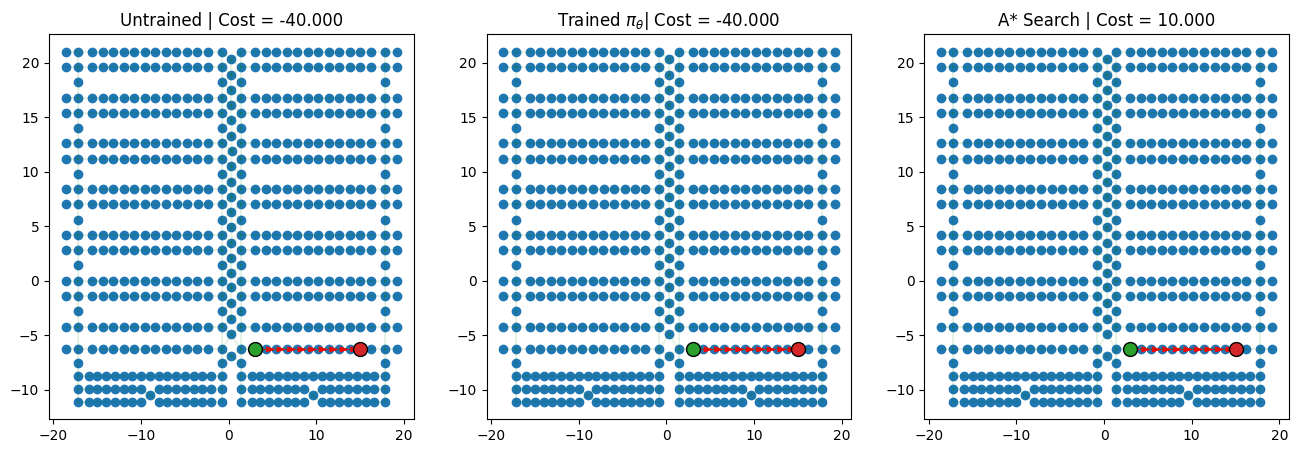

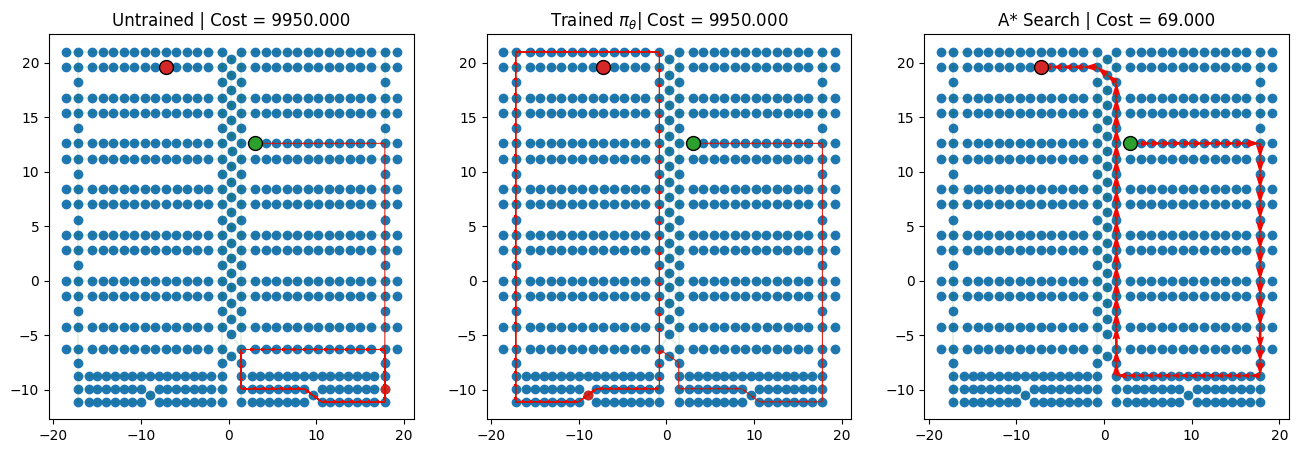

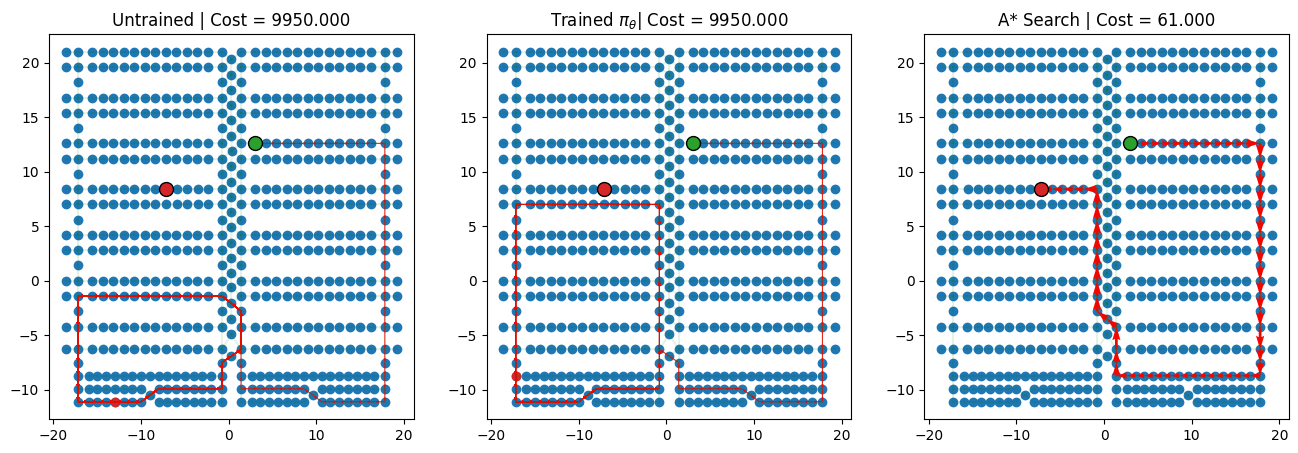

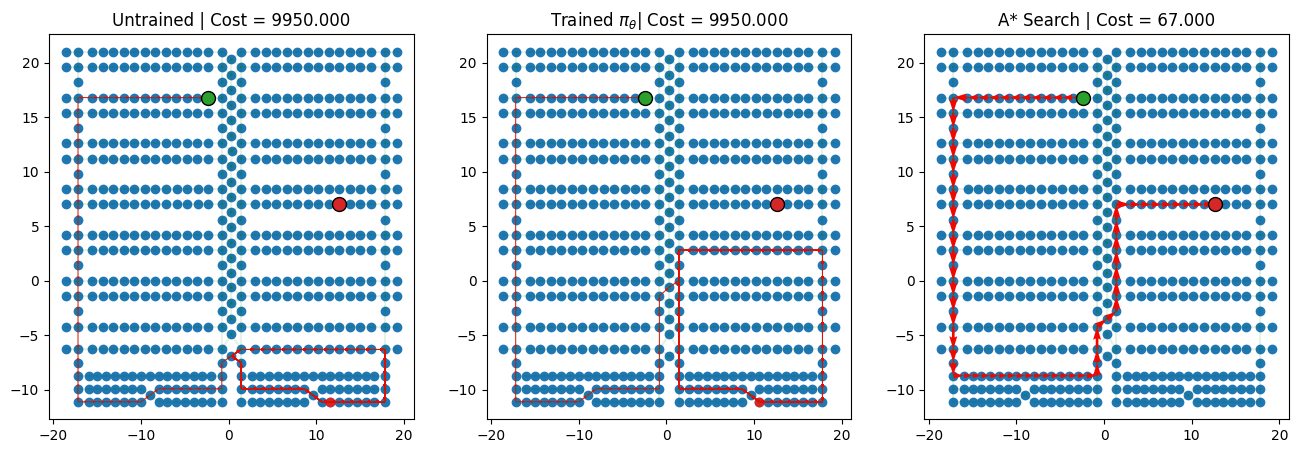

In [8]:
from astar import AStarSearch

# infer_env = SPPEnv(num_loc=500)
#from SPPenv import SPPEnv
#infer_env = SPPDynamicEnv(num_loc=100)
# infer_env = SPPEnv(num_loc=100)

# td_init = env.reset(batch_size=[3]).to(device)

# model = model.to(device)
# out = model(td_init.clone(),env=env, phase="test", decode_type="greedy",
# return_actions=True)
# actions_trained = out['actions'].cpu().detach()

policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,3, figsize=(16,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")

    env.render(td, actions_trained[i], ax=axs[1])
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    env.render(td, actions_astar[i], ax=axs[2])
    axs[2].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))

# Test trained model on grid map with obstacles

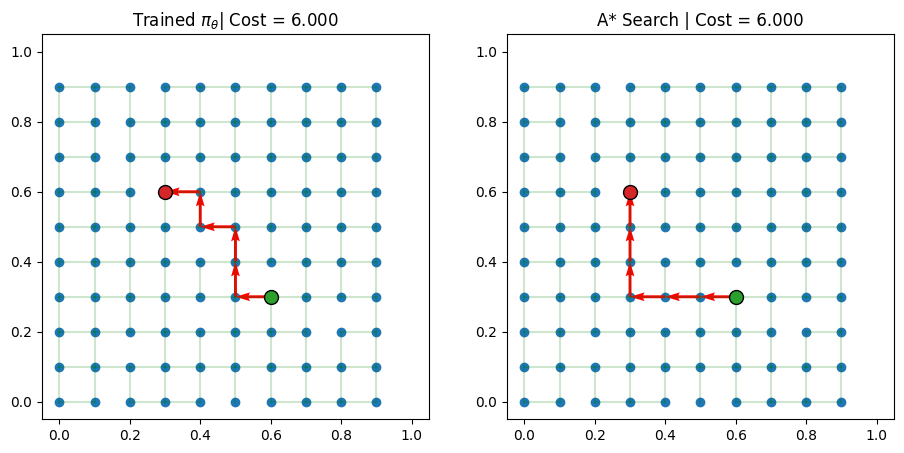

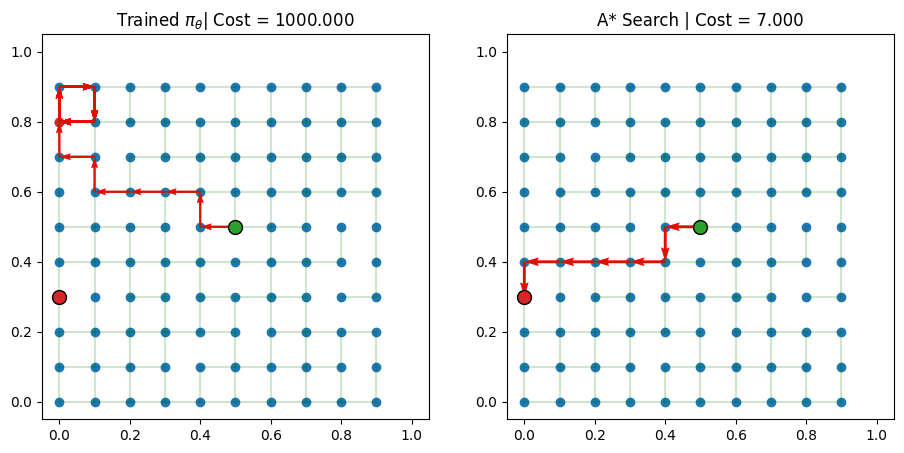

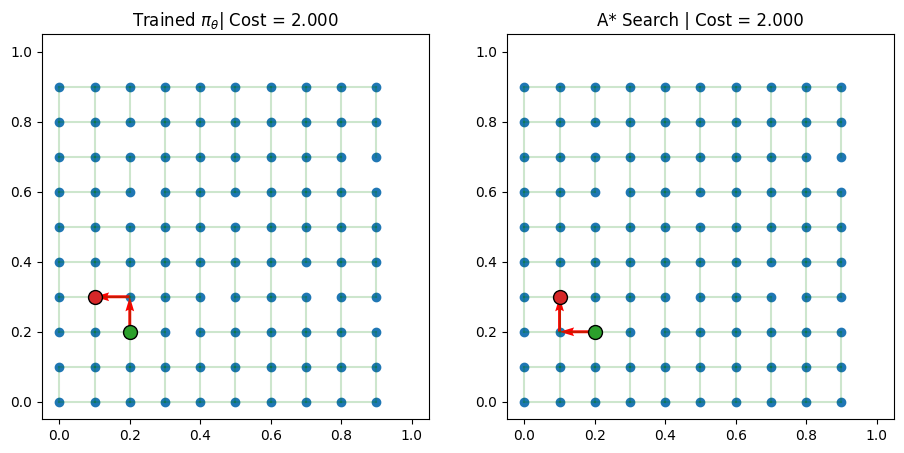

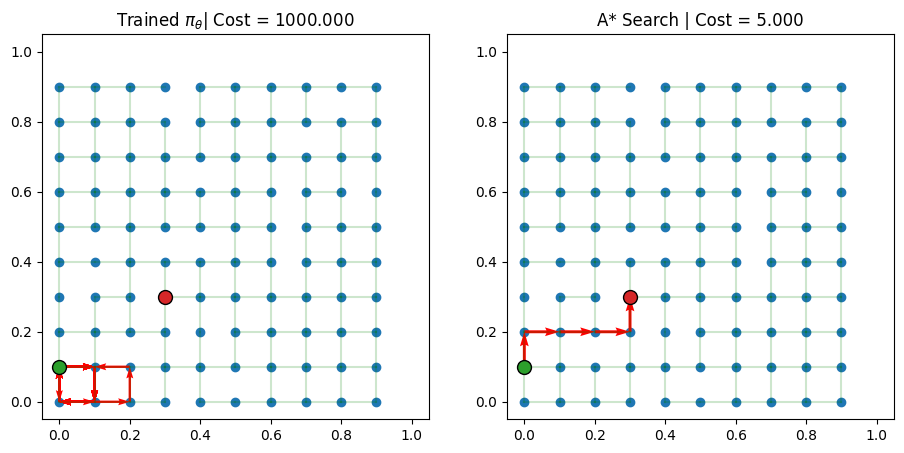

In [9]:
from SPPv2env import SPPv2Env

infer_env = SPPv2Env(num_loc=100)
td_init = infer_env.reset(batch_size=[4]).to(device)

policy = model.policy.to(device)
out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))

    infer_env.render(td, actions_trained[i], ax=axs[0])
    axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    infer_env.render(td, actions_astar[i], ax=axs[1])
    axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))

In [10]:
# import numpy as np
# # Initialize the total costs
# total_cost_trained = 0
# total_cost_astar = 0
# cost_list_trained = np.array([])
# cost_list_astar = np.array([])
# 
# # Number of runs
# num_runs = 100
# 
# batch_size = 10
# 
# # Initialize the action lists
# actions_trained = []
# actions_astar = []
# 
# # Initialize the TensorDict list
# td_list = []
# 
# for _ in range(num_runs):
#     while True:
#         try:
#             # Initialize the action lists for the current run
#             actions_trained_run = []
#             actions_astar_run = []
# 
#             # infer_env = SPPEnv(num_loc=100)
#             # td_init = infer_env.reset(batch_size=[batch_size]).to(device)
# 
#             infer_env = SPPv2Env(num_loc=100)
#             td_init = infer_env.reset(batch_size=[batch_size]).to(device)
# 
#             # Run the trained DRL model
#             out = policy(td_init.clone(), infer_env, phase="test", decode_type="multistart_greedy", return_actions=True)
#             total_cost_trained += out['reward'].sum().item()
# 
#             # Run A* search
#             astar = AStarSearch(td_init.clone())
#             astar_out = astar.search()
#             total_cost_astar += astar_out["reward"].sum().item()
# 
#             # Store the TensorDict
#             td_list.append(td_init)
# 
#             # Store the output of the astar and trained model
#             actions_trained.append(out["actions"].cpu().detach())
#             actions_astar.append(astar_out["actions"].cpu().detach())
# 
#             # Store the cost of the trained model and A* search
#             cost_list_trained = np.append(cost_list_trained, out["reward"].cpu().detach().numpy())
#             cost_list_astar = np.append(cost_list_astar, astar_out["reward"].cpu().detach().numpy())
# 
#             break
#         except:
#             continue
# 
#     # Append the action lists for the current run to the overall action list
#     # actions_trained.append(actions_trained_run)
#     # actions_astar.append(actions_astar_run)
# 
# # How many -1000 rewards are there in the trained DRL model
# nosols_trained = np.sum(cost_list_trained == -1000)
# print(f"Number of unsolved problems in trained DRL model: {nosols_trained}")
# 
# # Remove all the -1000 rewards
# cost_list_trained_filtered = cost_list_trained[cost_list_trained != -1000]

In [11]:
# # Calculate the average costs
# print ("Mean cost of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_trained_filtered.mean()))
# print ("Mean cost of A* search over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_astar.mean()))
# 
# # Calculate the mean and standard deviation of the costs
# print ("Median cost of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, np.median(cost_list_trained_filtered)))
# print ("Median cost of A* search over {} runs: {:.3f}".format(num_runs * batch_size, np.median(cost_list_astar)))
# print ("Standard deviation of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_trained_filtered.std()))
# print ("Standard deviation of A* search over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_astar.std()))
# 
# # Plot the histogram of the costs
# plt.hist(cost_list_trained_filtered, bins=20, alpha=0.7, label='Trained DRL Model')
# plt.hist(cost_list_astar, bins=20, alpha=0.7, label='A* Search')
# plt.legend(loc='upper right')
# plt.xlabel('Cost')
# plt.ylabel('Frequency')
# plt.title('Histogram of costs')
# plt.show()
# 
# # Get the indices of the runs with the highest costs
# worst_runs = np.argsort(cost_list_astar)[::-1][-3:]
# print(worst_runs)
# print(cost_list_astar[worst_runs])
# 
# # Plot the actions for the first run
# import matplotlib.pyplot as plt
# 
# for run in worst_runs:
#     quotient, remainder = divmod(run, batch_size)
#     print(quotient, remainder)
#     for i, td in enumerate(td_list[quotient]):
#         if i == remainder:
#             fig, axs = plt.subplots(1,2, figsize=(11,5))
# 
#             try:
#                 infer_env.render(td, actions_trained[quotient][i], ax=axs[0])
#                 axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {cost_list_trained[run]:.3f}")
#             except Exception as e:
#                 print(e)
#                 print("Error in plotting trained model")
#                 pass
# 
#             infer_env.render(td, actions_astar[quotient][i], ax=axs[1])
#             axs[1].set_title("A* Search | Cost = {:.3f}".format(cost_list_astar[run]))
# 
# # Plot the actions with the largest difference between the trained model and A* search
# diff = - cost_list_trained + cost_list_astar
# largest_diffs = np.argsort(diff)[::-1][:3]
# print(largest_diffs)
# 
# for run in largest_diffs:
#     quotient, remainder = divmod(run, batch_size)
#     print(quotient, remainder)
#     for i, td in enumerate(td_list[quotient]):
#         if i == remainder:
#             fig, axs = plt.subplots(1,2, figsize=(11,5))
# 
#             try:
#                 infer_env.render(td, actions_trained[quotient][i], ax=axs[0])
#                 axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {cost_list_trained[run]:.3f}")
#             except Exception as e:
#                 print(e)
#                 print("Error in plotting trained model")
#                 pass
# 
#             infer_env.render(td, actions_astar[quotient][i], ax=axs[1])
#             axs[1].set_title("A* Search | Cost = {:.3f}".format(cost_list_astar[run]))

# Real Floorplan Path Finding with Reinforcement Learning and Astar Search

## Salt Lake City Floorplan


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([-9950.,    20., -9950.,    43.], device='cuda:0')


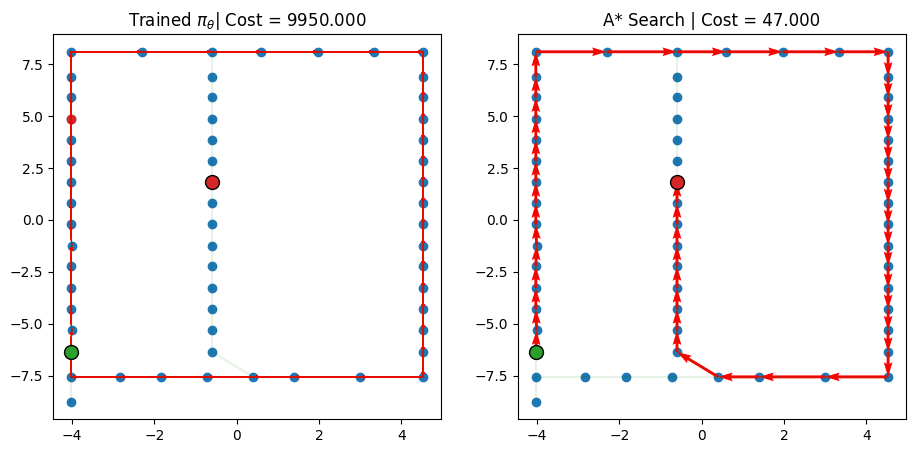

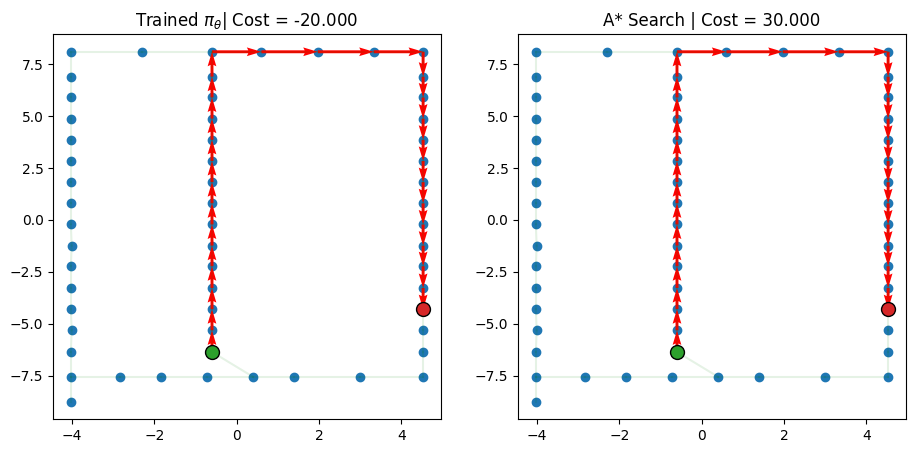

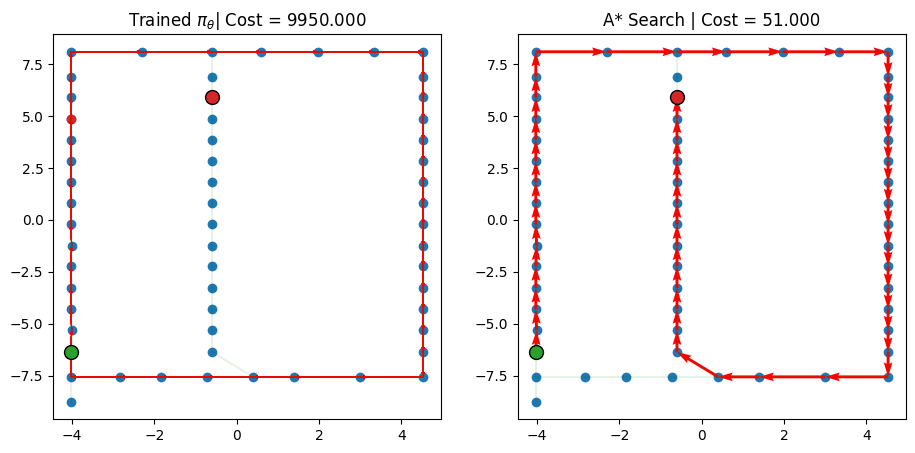

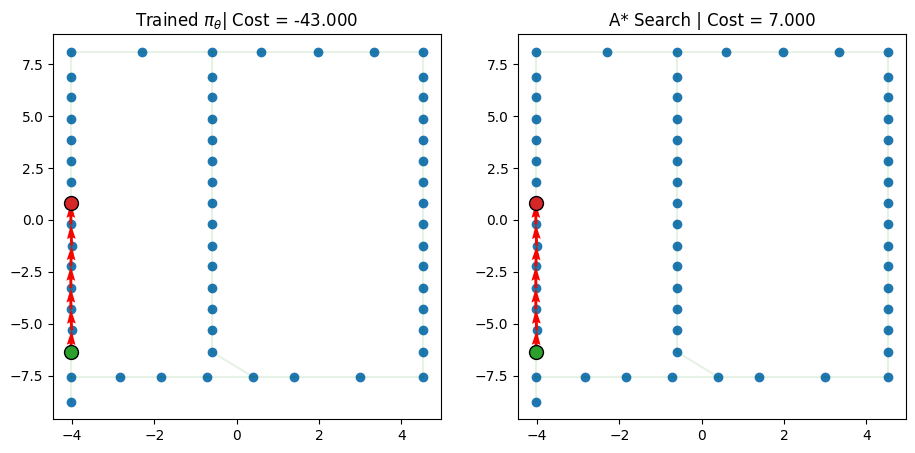

In [12]:
from FPenv import FPEnv
from astar import AStarSearch
import torch

# Setup a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

infer_env = FPEnv(fp_path="Floorplans/USPS/0026_Salt_Lake_City/floorplan.json")
td_init = infer_env.reset(batch_size=[4]).to(device)


# Function to check for NaNs in a tensor dictionary
nan_found = False
for key, tensor in td_init.items():
    if torch.isnan(tensor).any():
        nan_found = True
        print(f"NaN values found in tensor '{key}'")
if not nan_found:
    print("No NaN values found in the tensor dictionary.")

policy = model.policy.to(device)

out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))

    infer_env.render(td, actions_trained[i], ax=axs[0])
    axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    infer_env.render(td, actions_astar[i], ax=axs[1])
    axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))


## Butterfly 14 x 11 Floorplan

batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([-9950., -9950., -9950., -9950.], device='cuda:0')


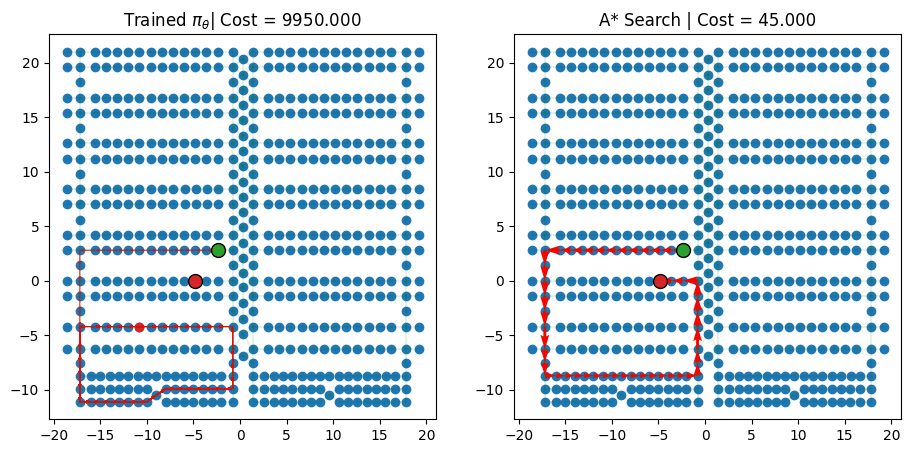

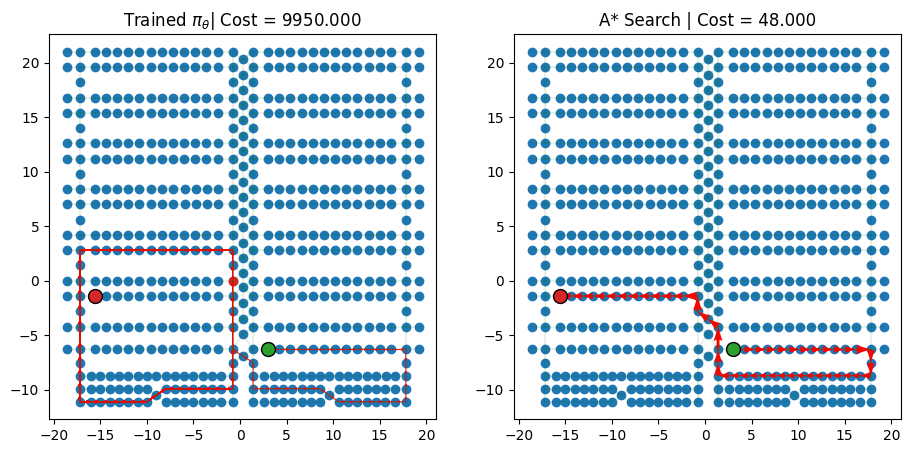

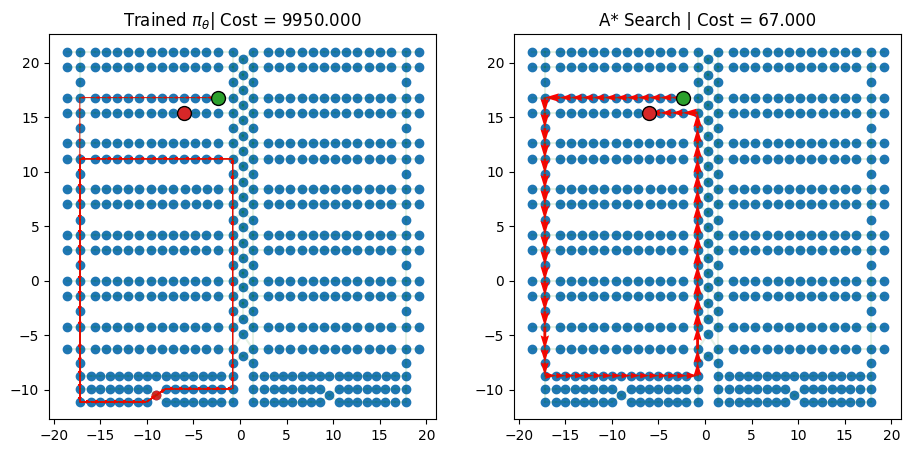

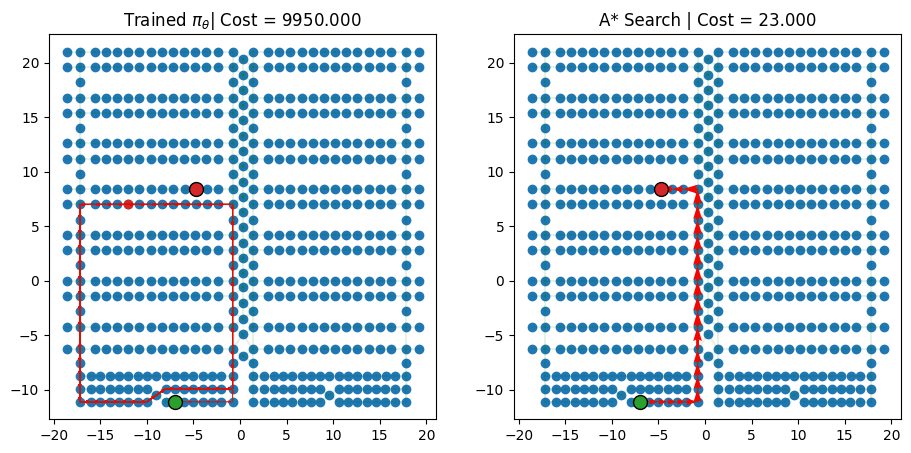

In [13]:
from FPenv import FPEnv
from astar import AStarSearch
import torch

# Setup a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

infer_env = FPEnv(fp_path="Floorplans/quad-infeed/butterfly/14x11/floorplan.json")
td_init = infer_env.reset(batch_size=[4]).to(device)


# Function to check for NaNs in a tensor dictionary
nan_found = False
for key, tensor in td_init.items():
    if torch.isnan(tensor).any():
        nan_found = True
        print(f"NaN values found in tensor '{key}'")
if not nan_found:
    print("No NaN values found in the tensor dictionary.")

policy = model.policy.to(device)

out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))

    infer_env.render(td, actions_trained[i], ax=axs[0])
    axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    infer_env.render(td, actions_astar[i], ax=axs[1])
    axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))


## All Floorplans

batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([   44., -9950.,    33., -9950.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([   40., -9950., -9950., -9950.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([   41.,    38., -9950.,    17.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([-9.9500e+03,  2.2000e+01,  4.6000e+01,  2.0000e+00], device='cuda:0')


batch_size in reset: [4]
random_ expects 'from' to be less than 'to', but got from=0 >= to=0
batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([   47.,    20., -9950., -9950.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([   47., -9950., -9950., -9950.], device='cuda:0')


/tmp/ipykernel_104082/2624096729.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1,2, figsize=(11,5))


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([-9.9500e+03, -1.4000e+01, -5.0000e+00, -9.9500e+03], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([-9950., -9950., -9950.,    13.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([   36.,    46.,    12., -9950.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([-9950.,    32.,    36.,    36.], device='cuda:0')


Expecting value: line 1 column 1 (char 0)
batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([-9950.,    27.,    36., -9950.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([   27., -9950., -9950., -9950.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.
reward:  tensor([13., 37., 13., 40.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([   33., -9950.,    34., -9950.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([   32., -9950., -9950., -9950.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([-9950.,    35., -9950.,    25.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.
reward:  tensor([28., 28., 38., 41.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.
reward:  tensor([16., 41., 35., 34.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([-9950.,   -19.,   -27.,    47.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.
reward:  tensor([ 36., -38.,   4.,  -6.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.
reward:  tensor([15., 27., 27., 39.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([-9.9500e+03,  2.7000e+01,  4.2000e+01, -6.0000e+00], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.
reward:  tensor([44., 44., 29., 35.], device='cuda:0')


batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([-9950., -9950.,    41., -9950.], device='cuda:0')
83
batch_size in reset: [4]
No NaN values found in the tensor dictionary.


reward:  tensor([   10., -9950., -9950.,    36.], device='cuda:0')


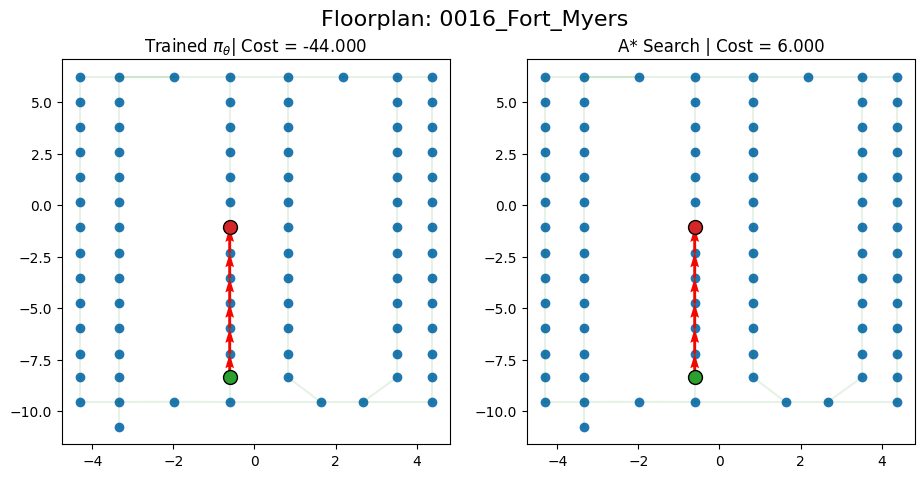

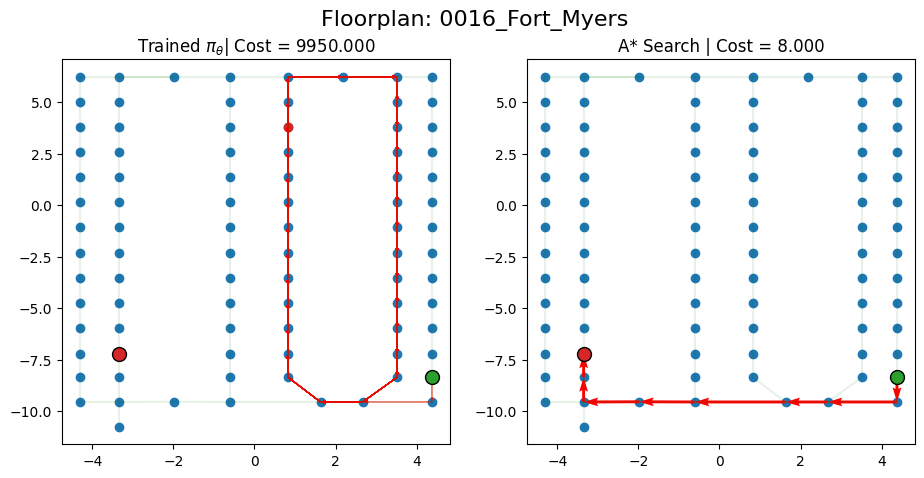

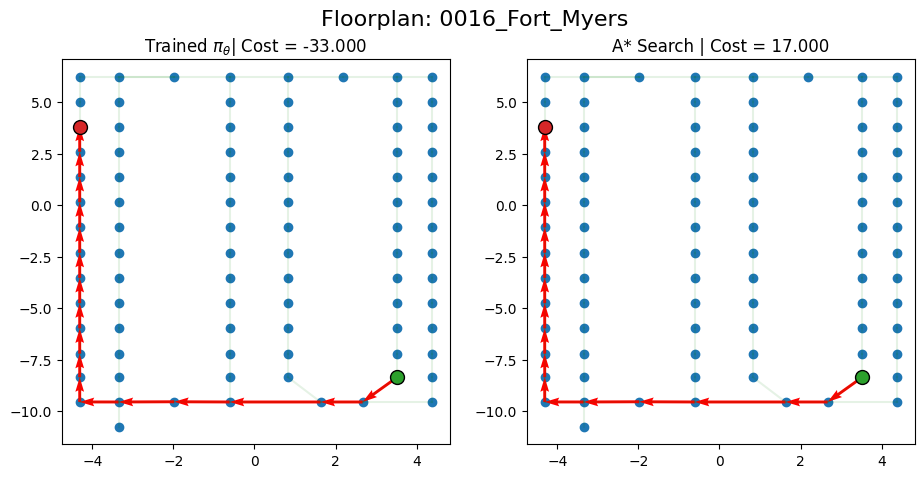

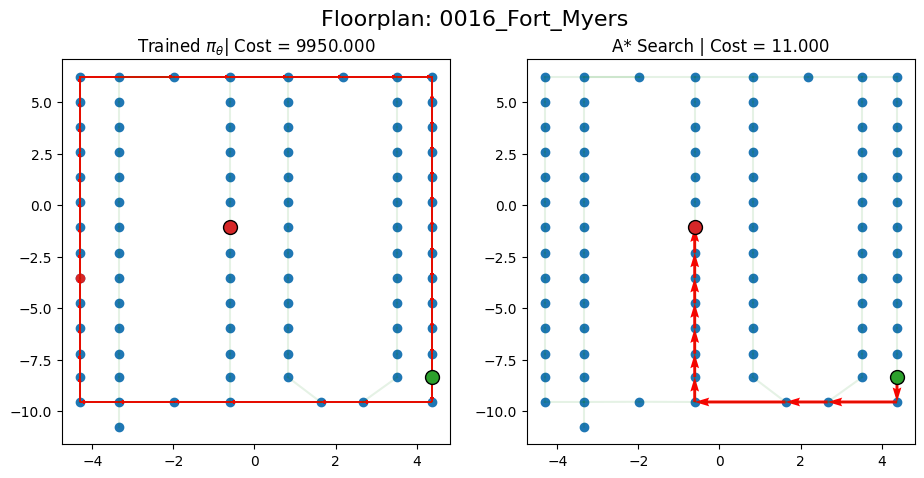

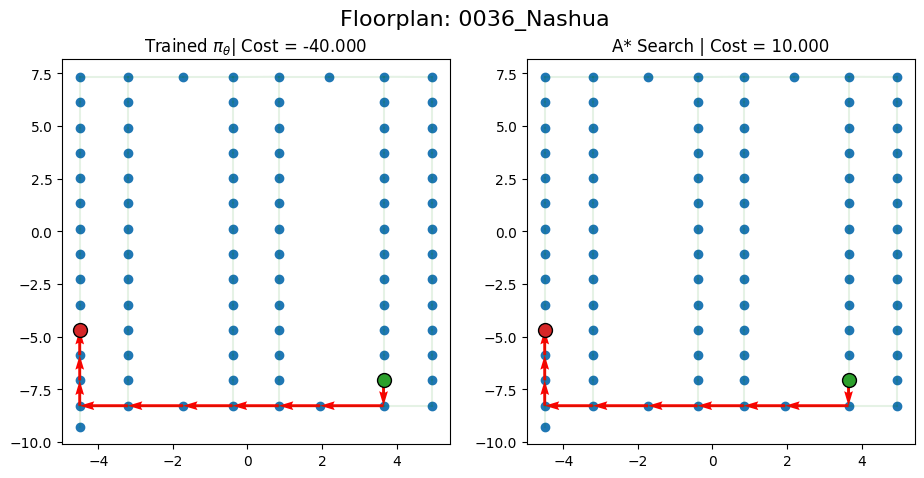

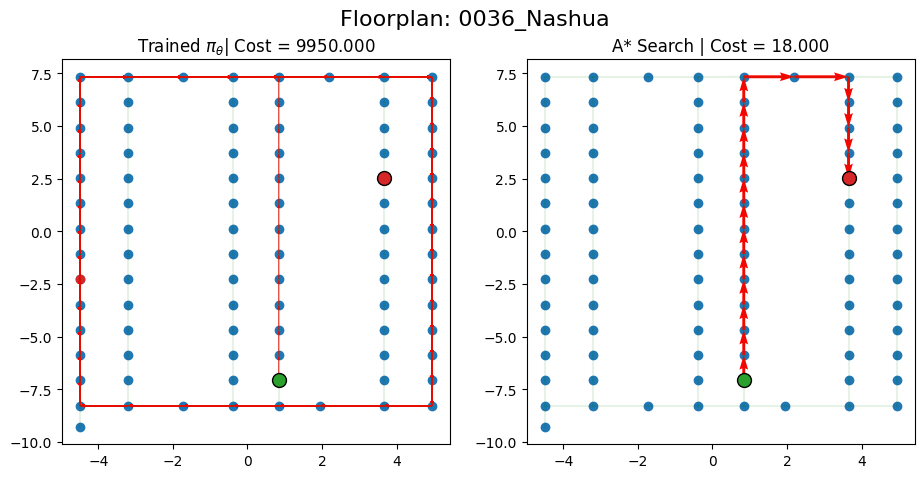

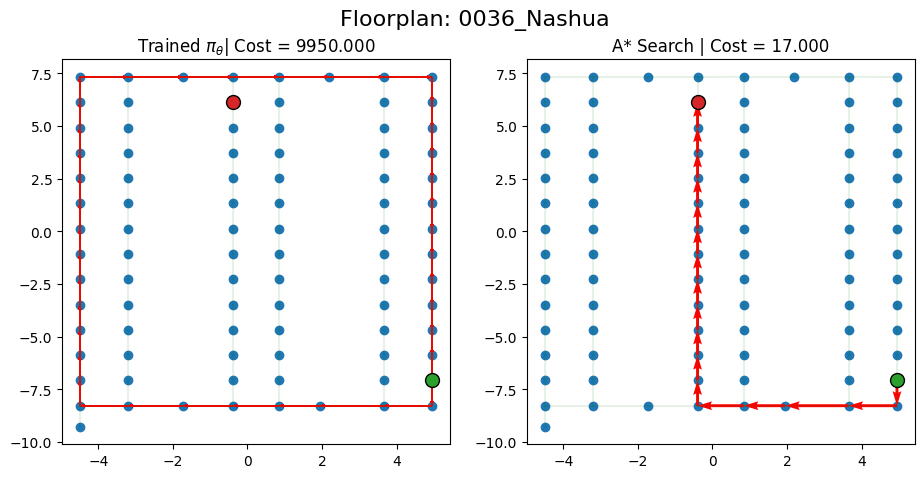

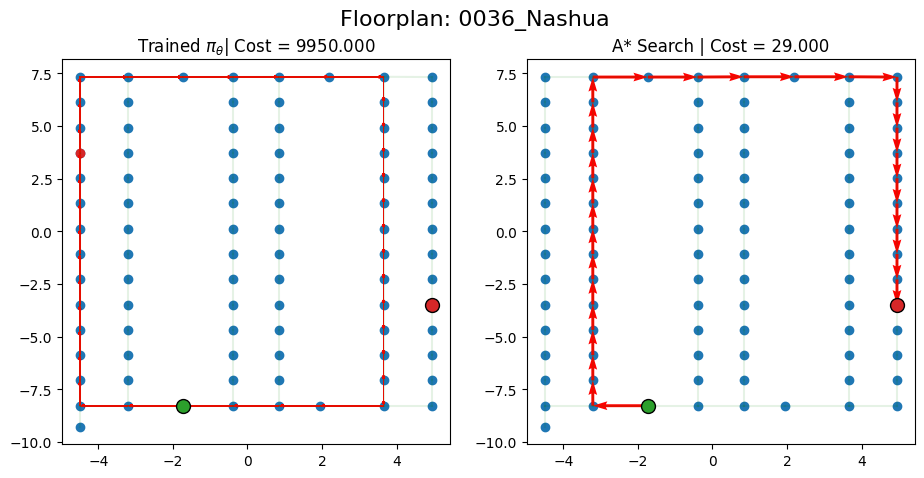

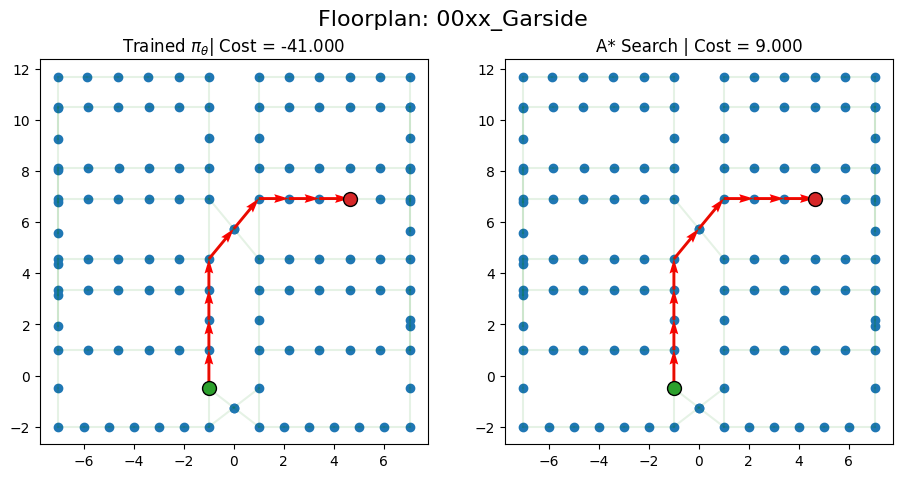

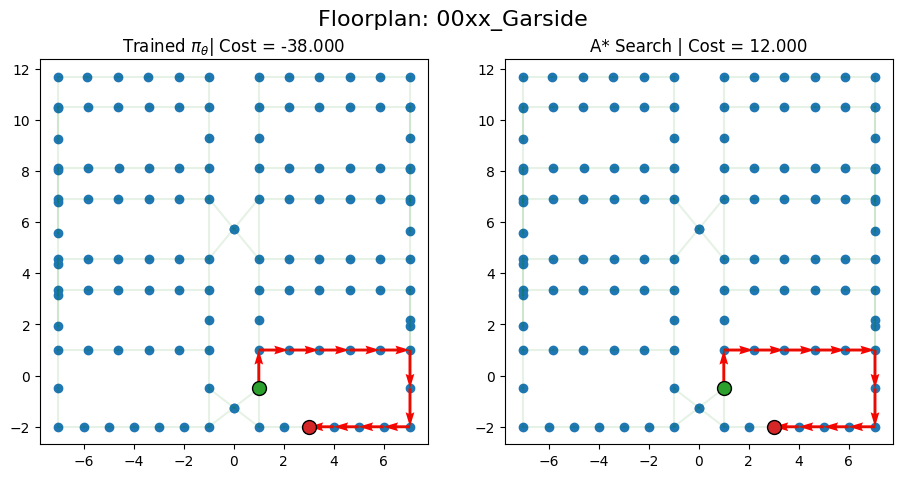

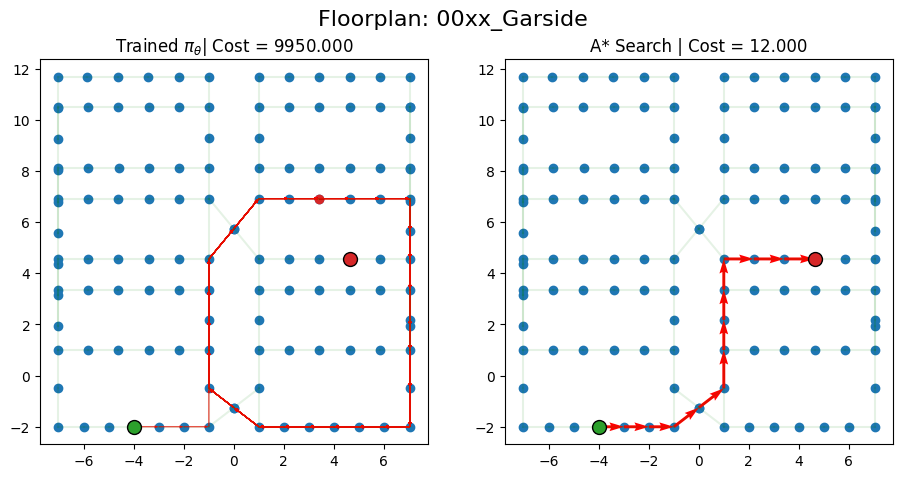

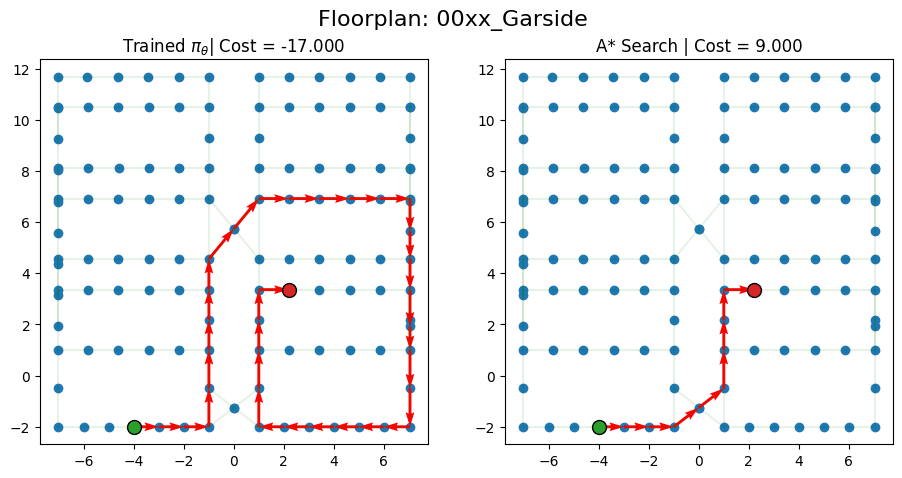

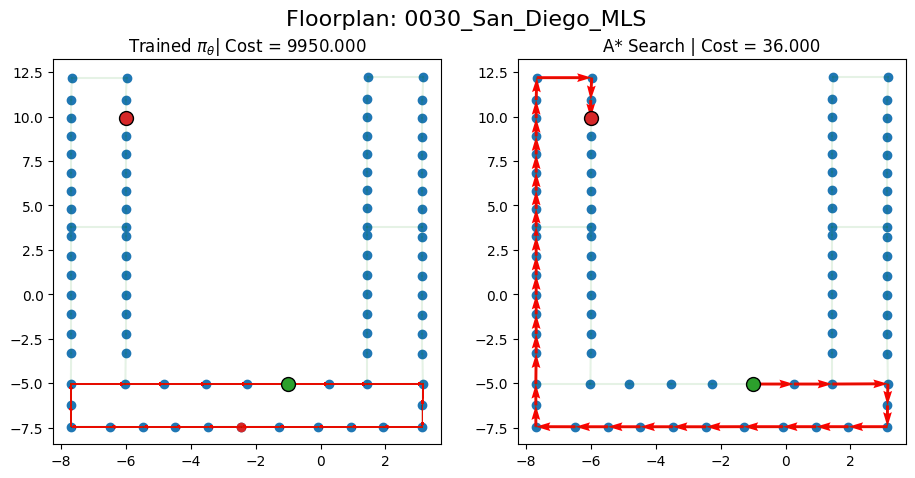

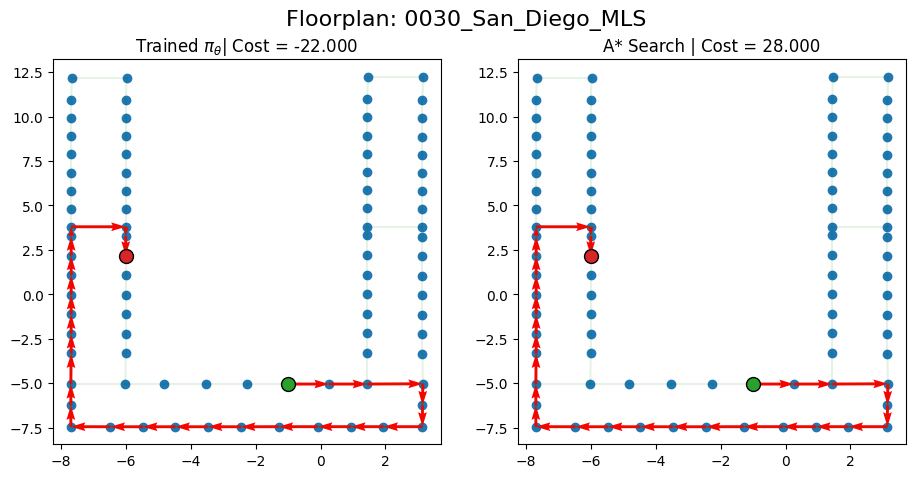

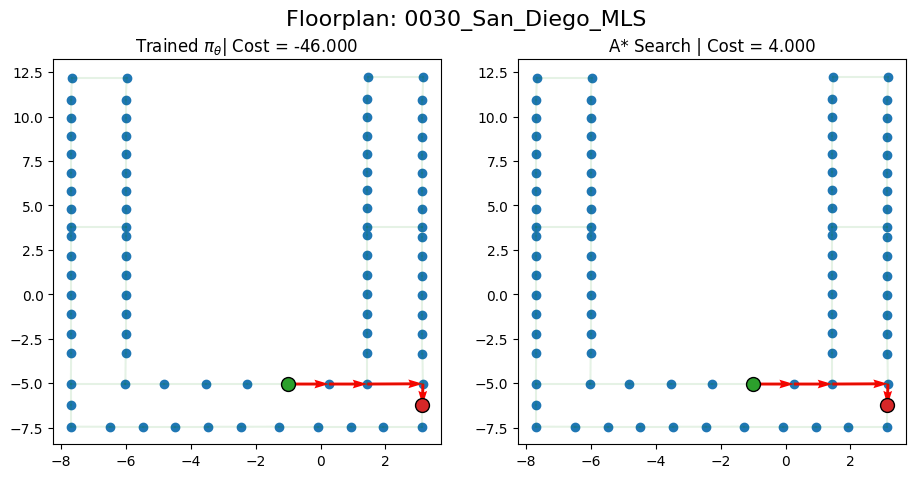

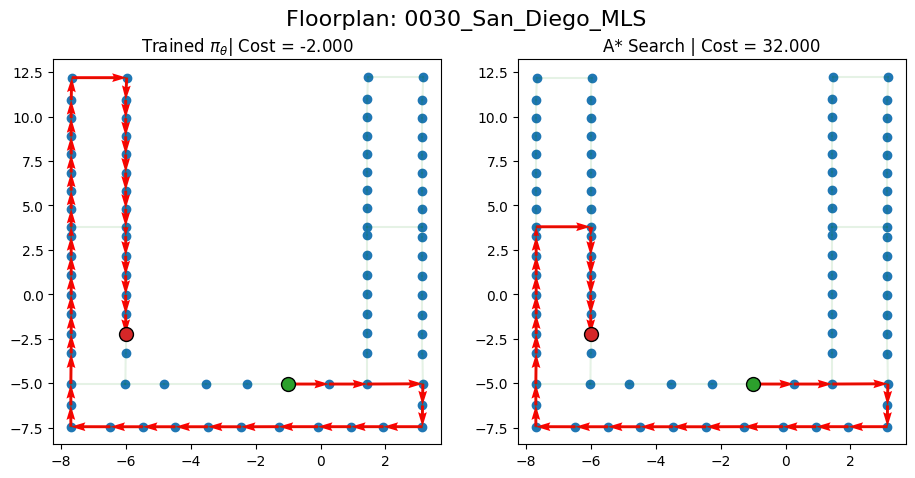

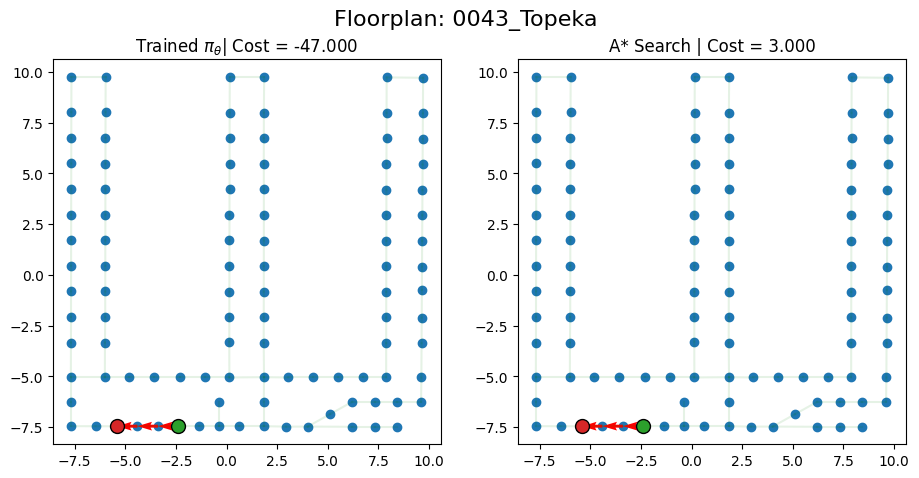

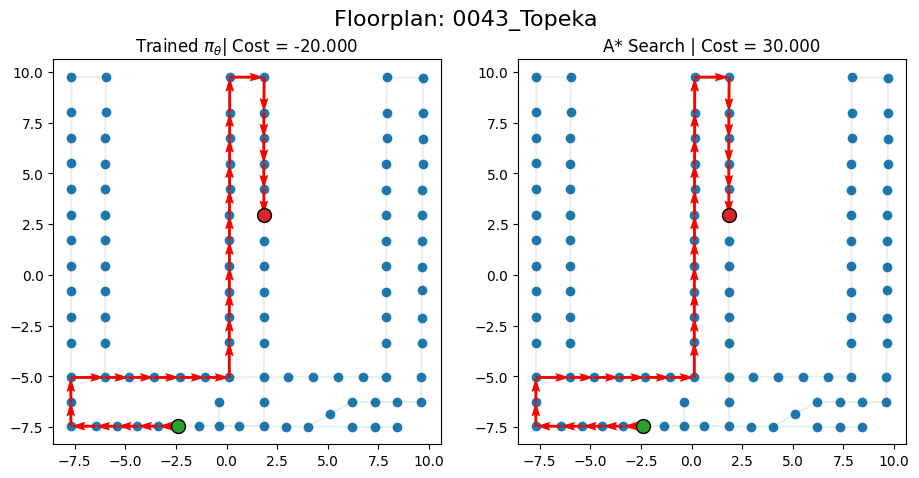

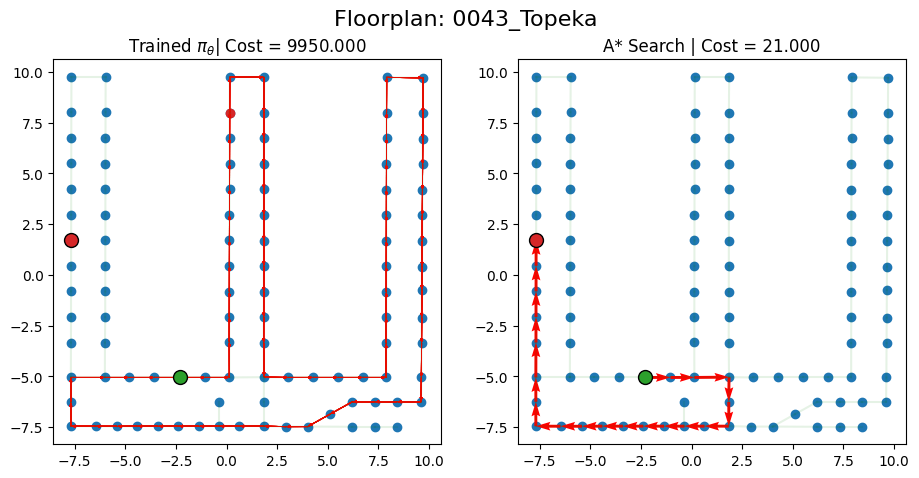

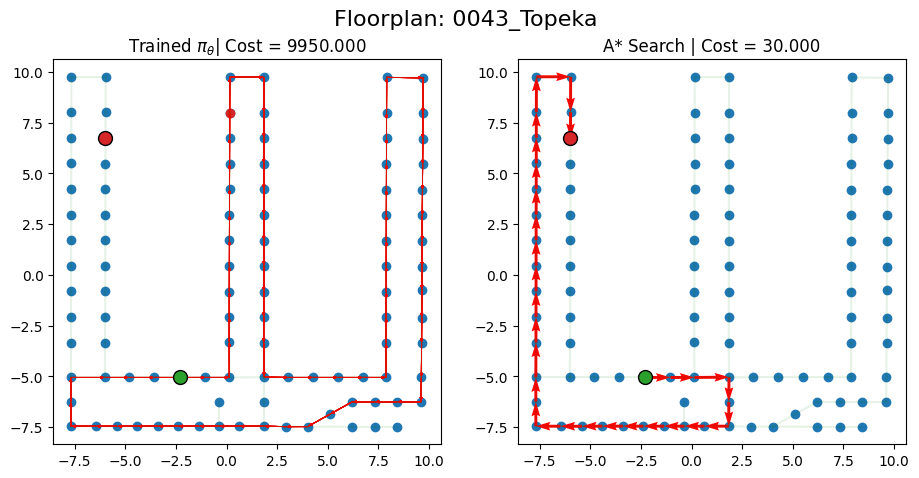

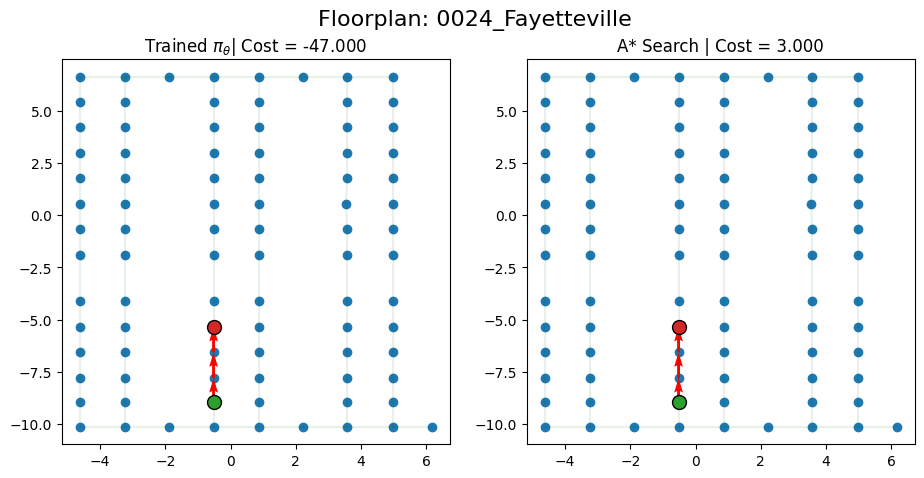

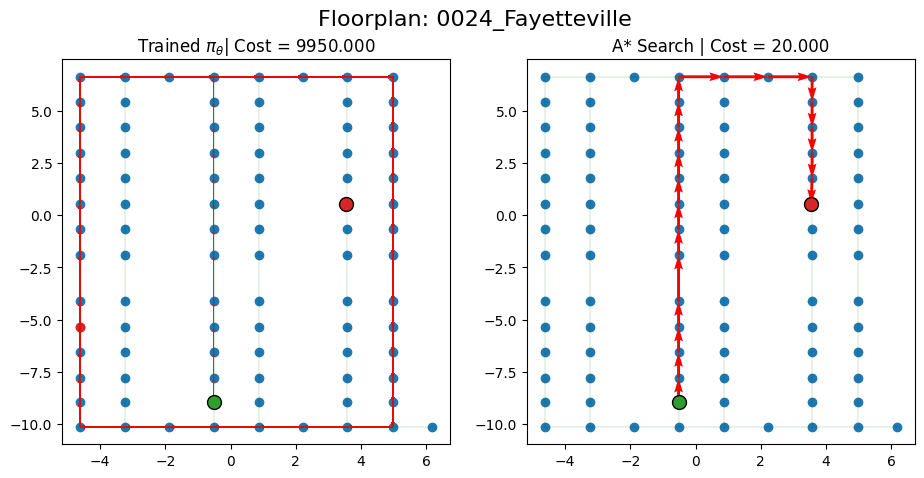

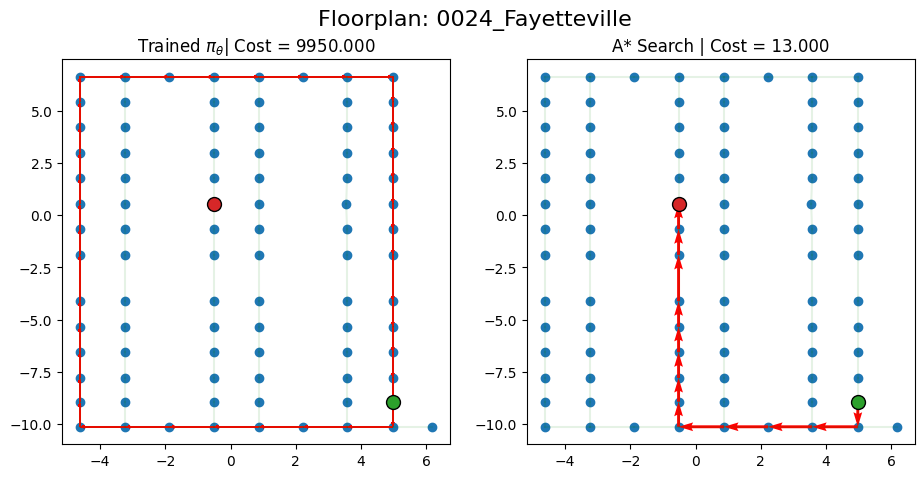

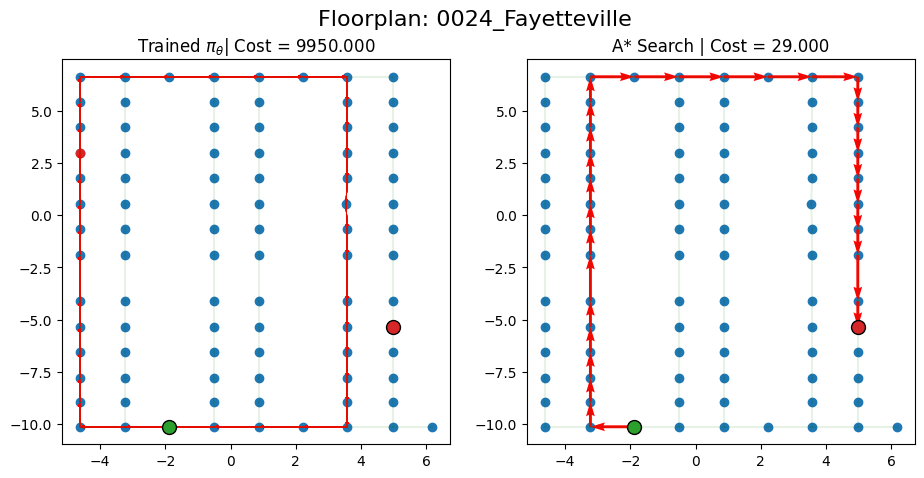

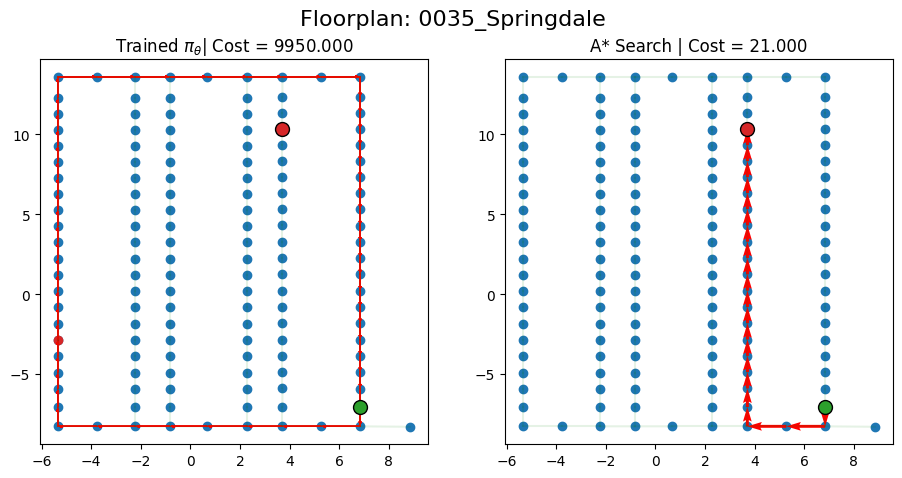

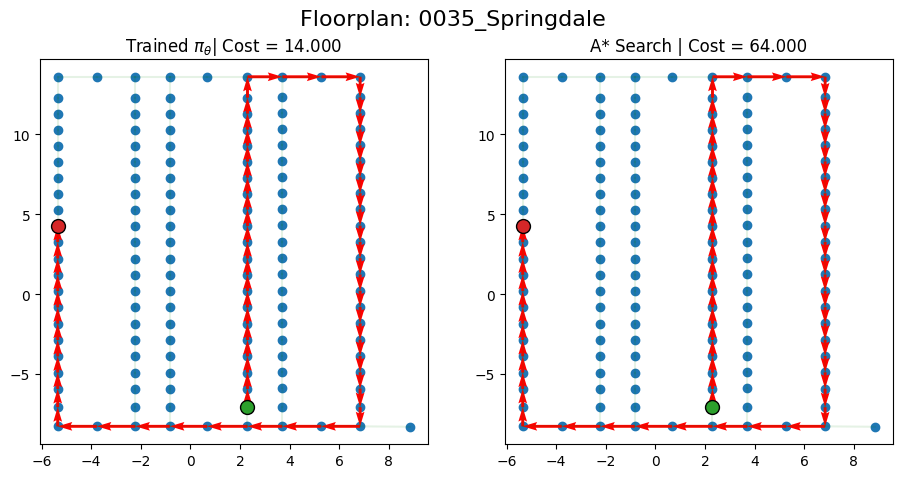

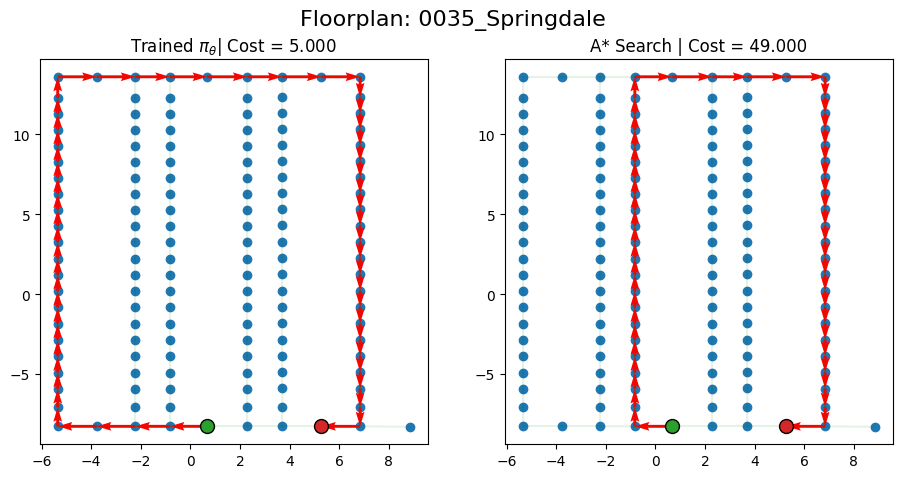

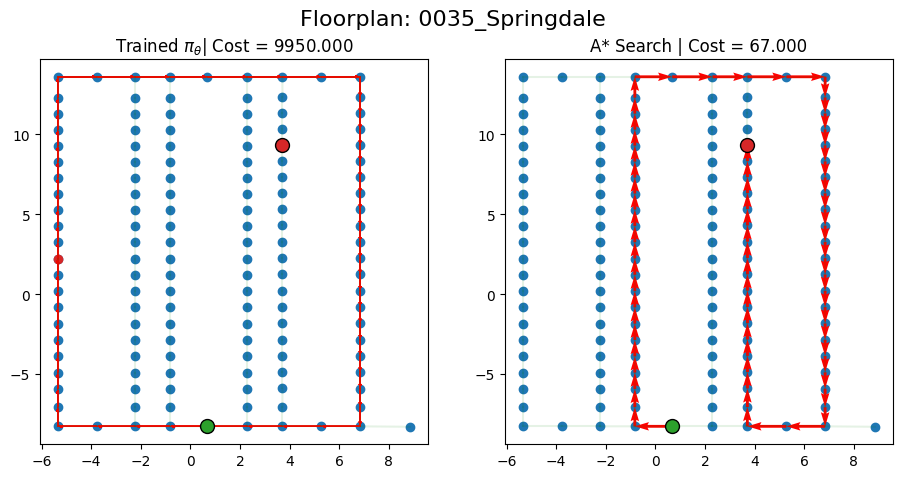

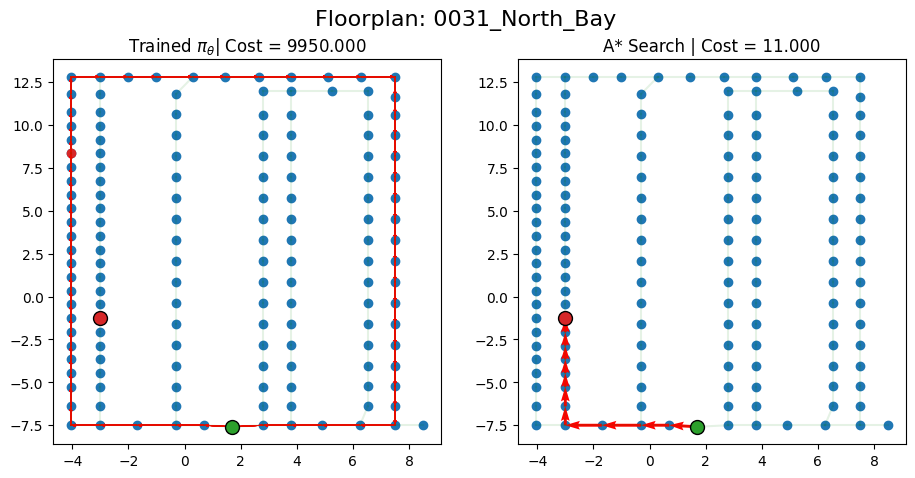

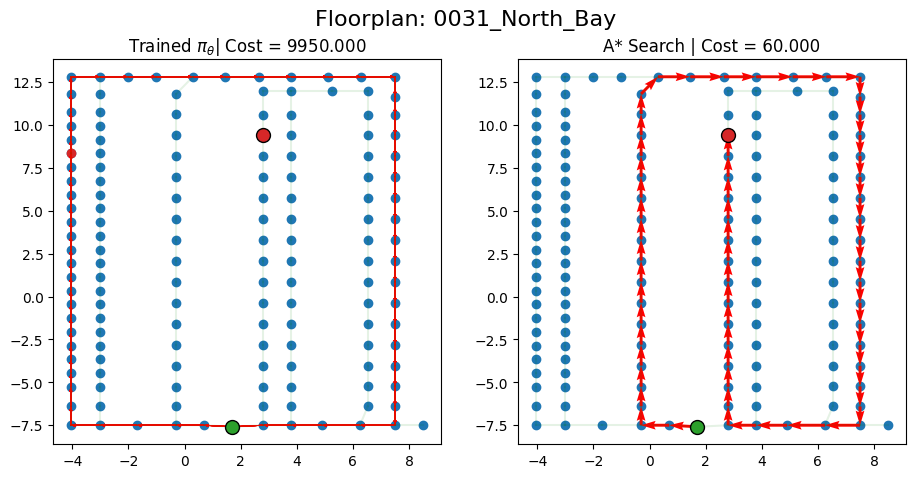

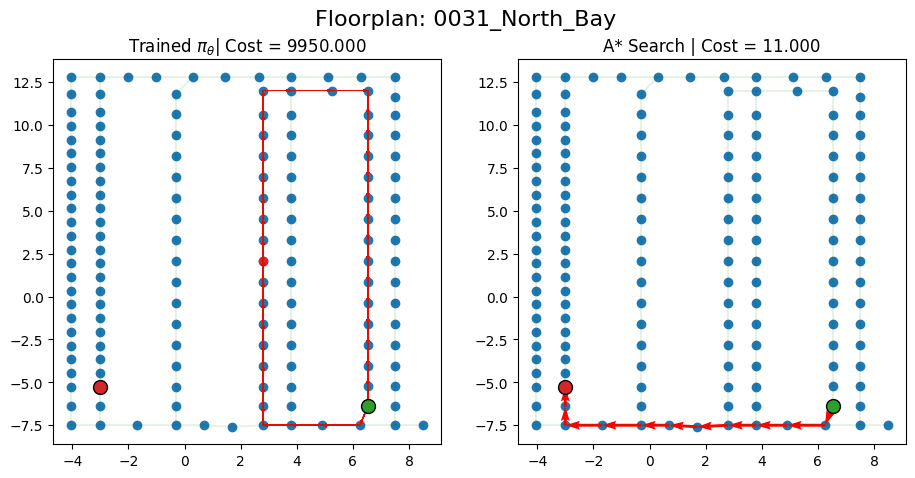

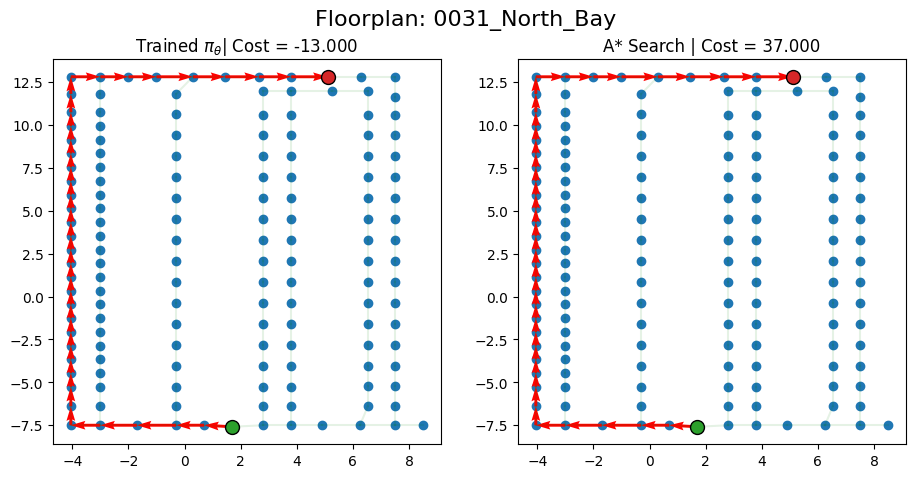

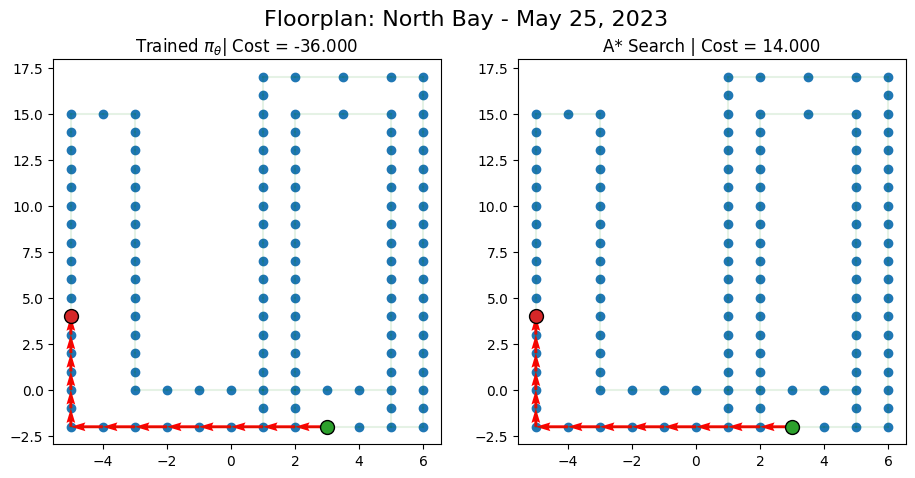

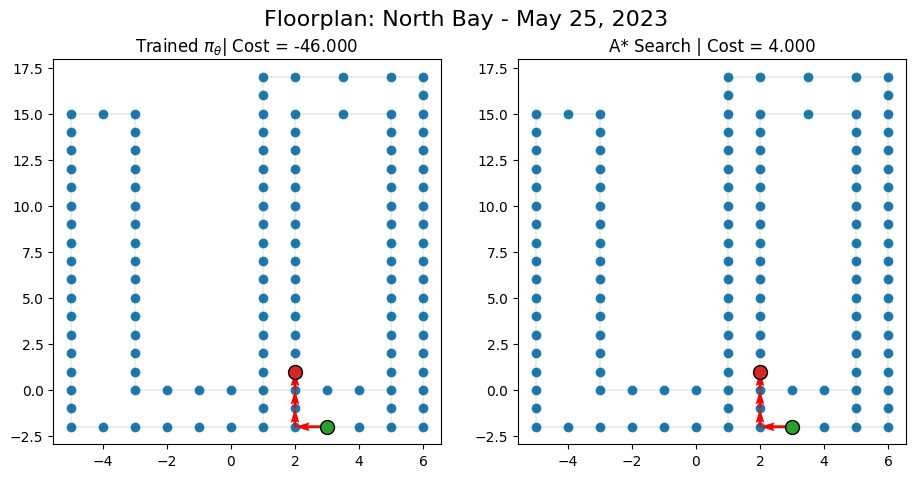

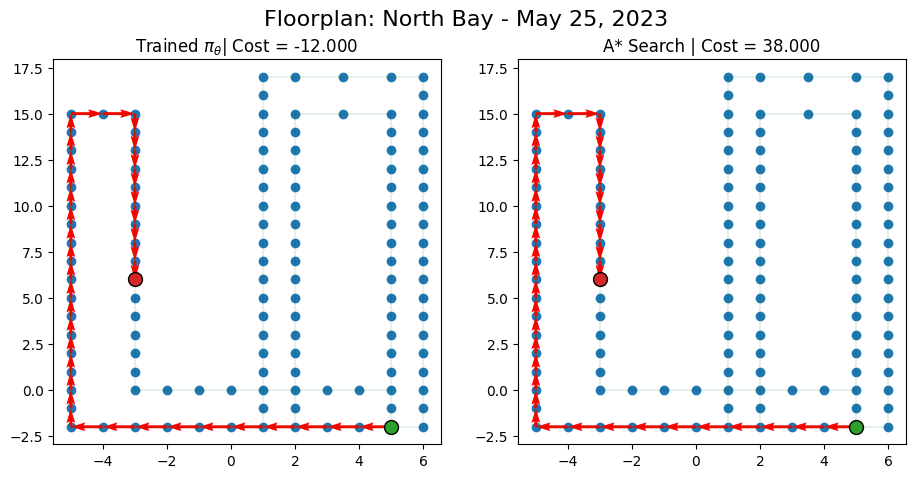

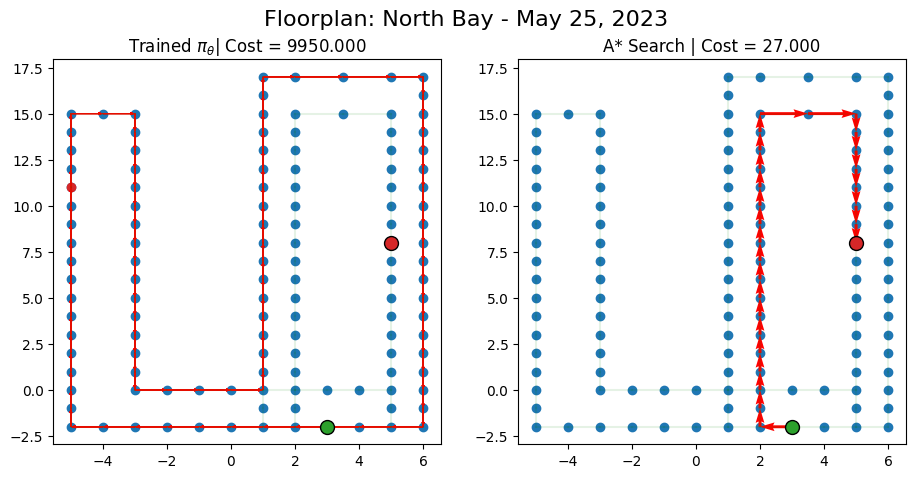

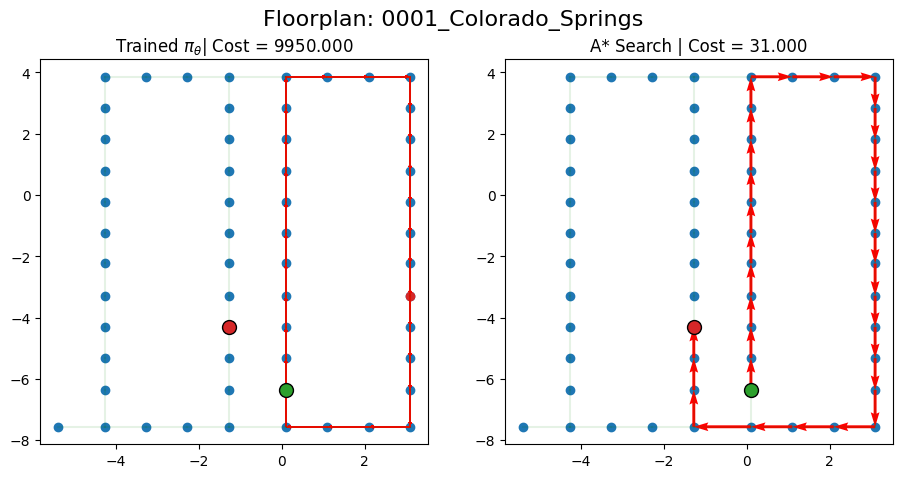

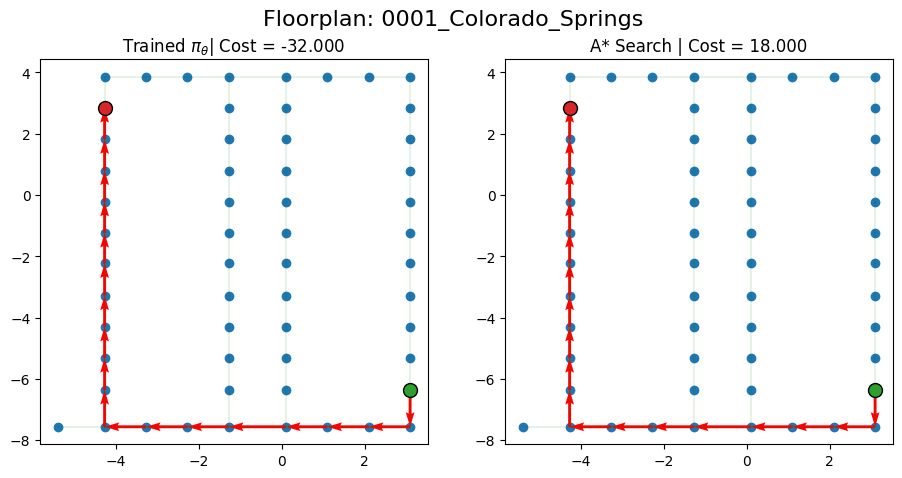

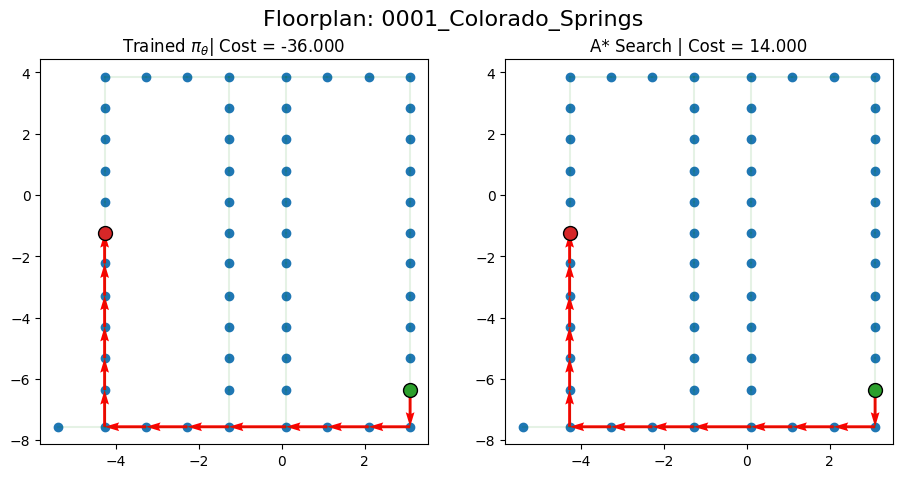

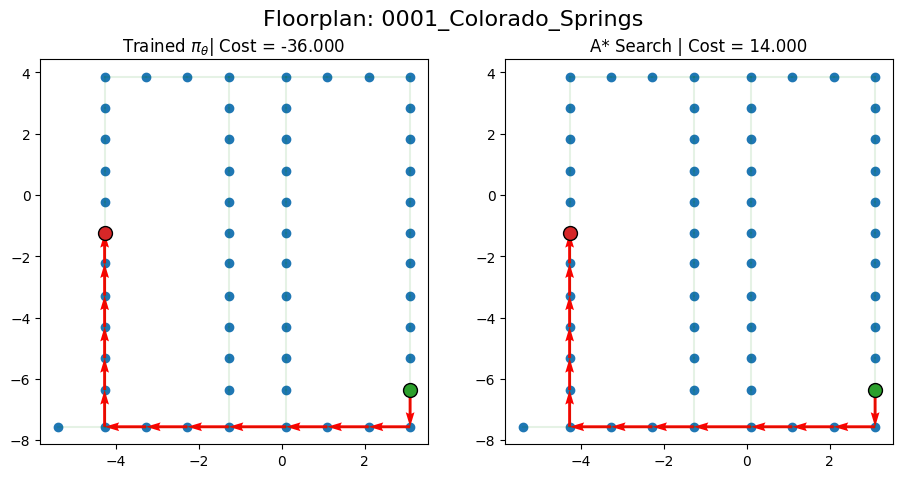

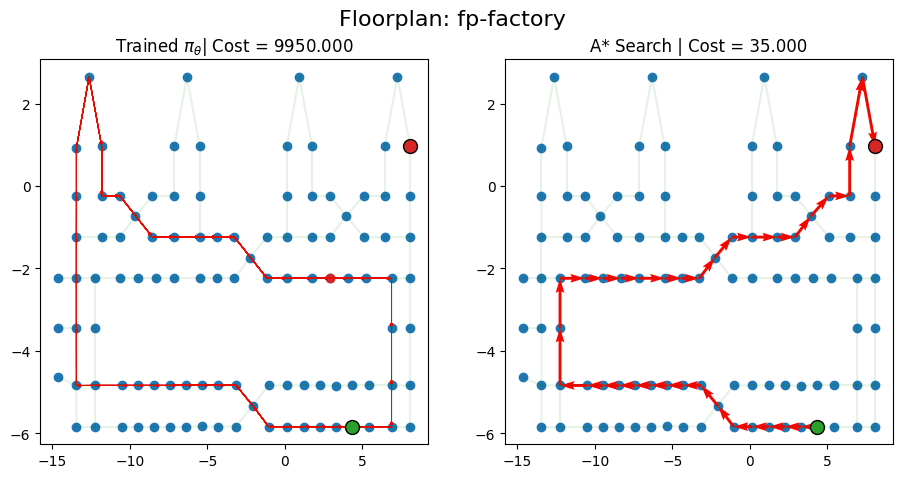

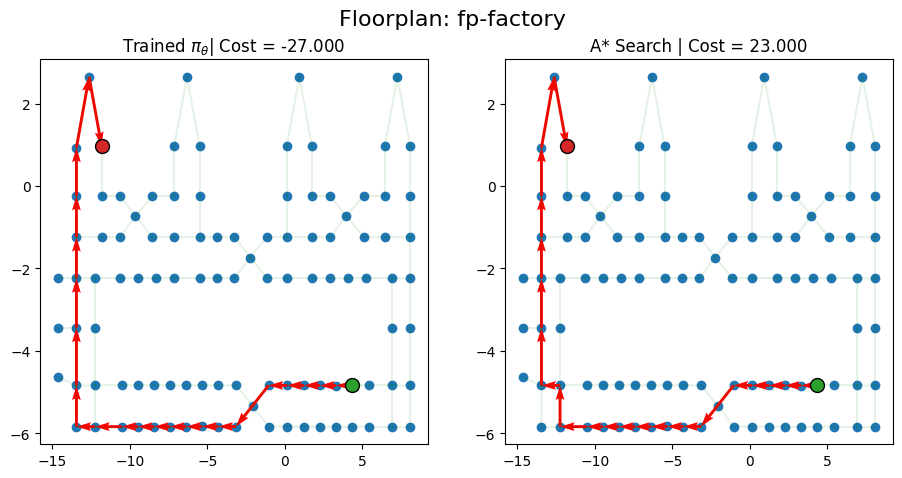

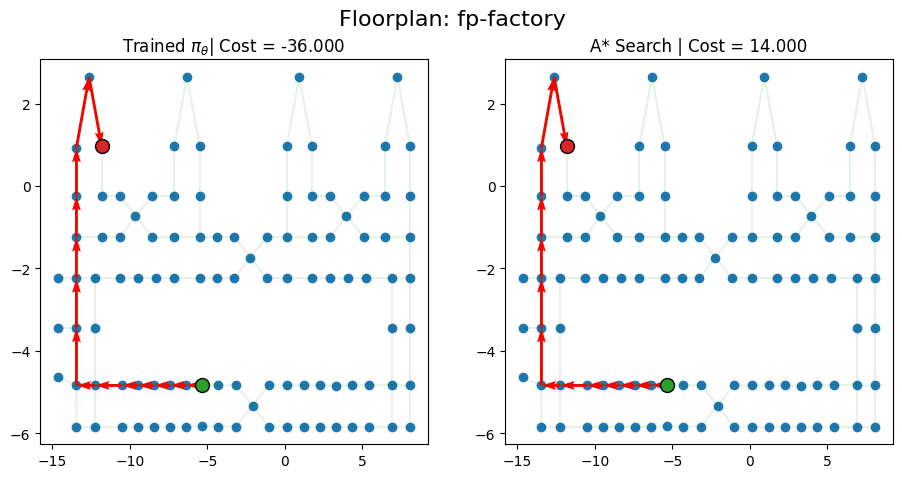

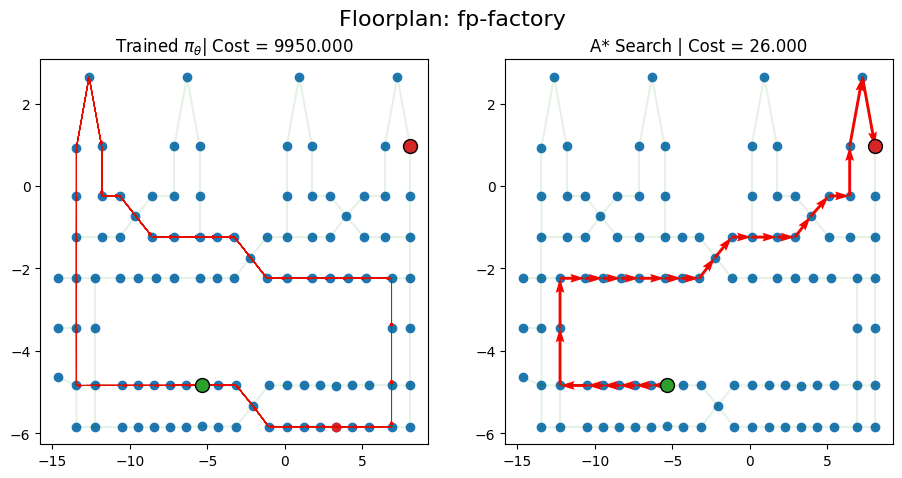

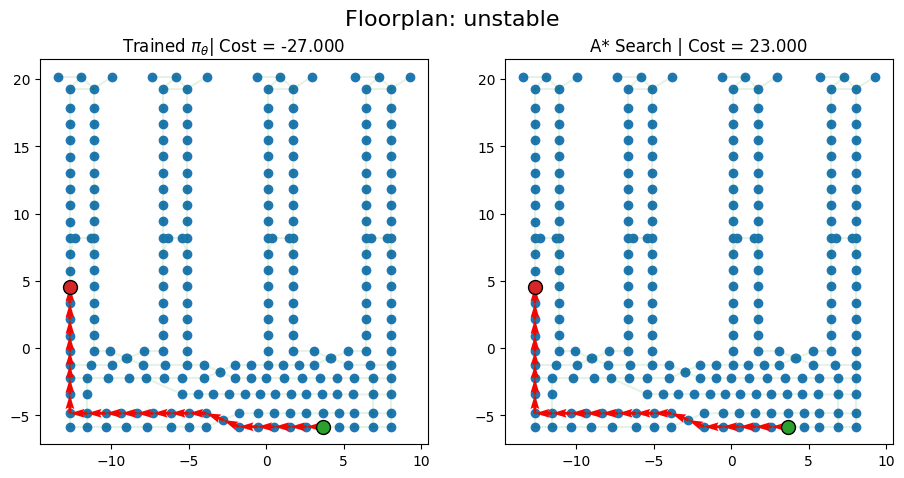

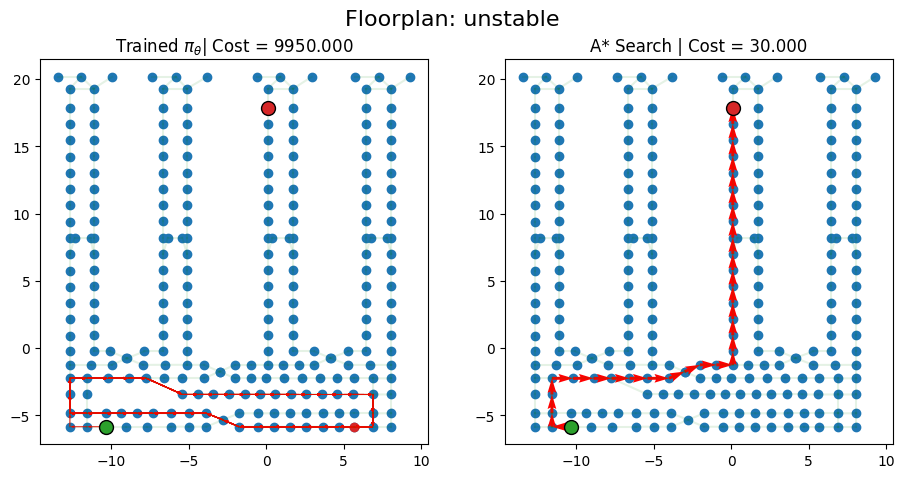

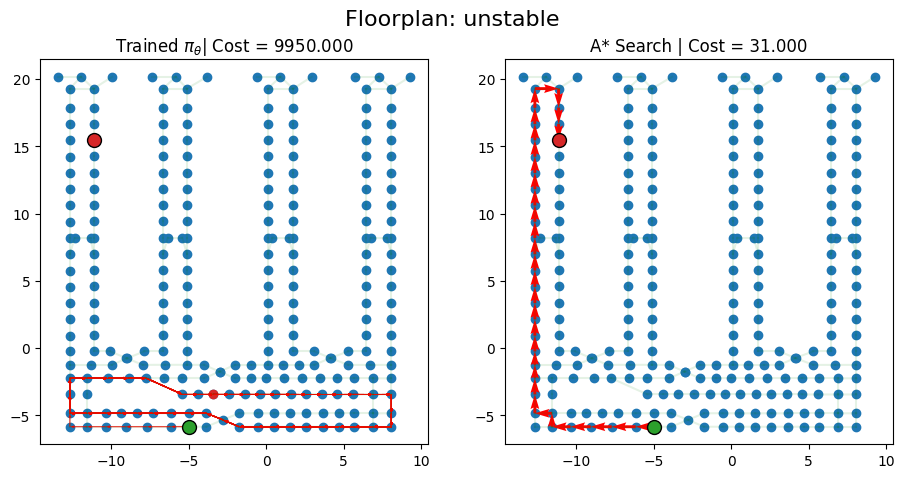

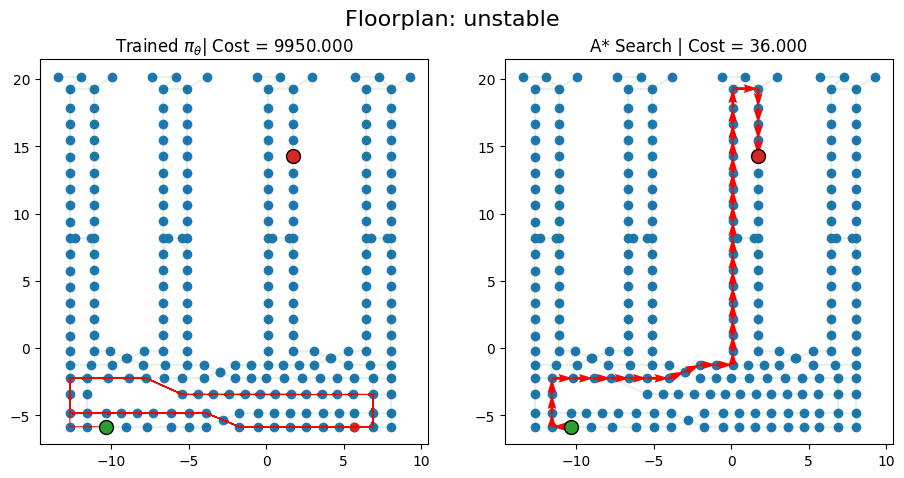

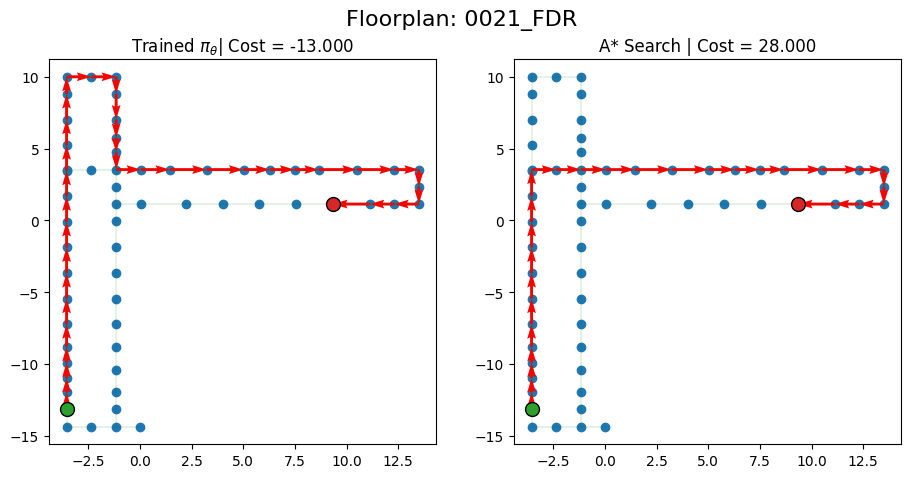

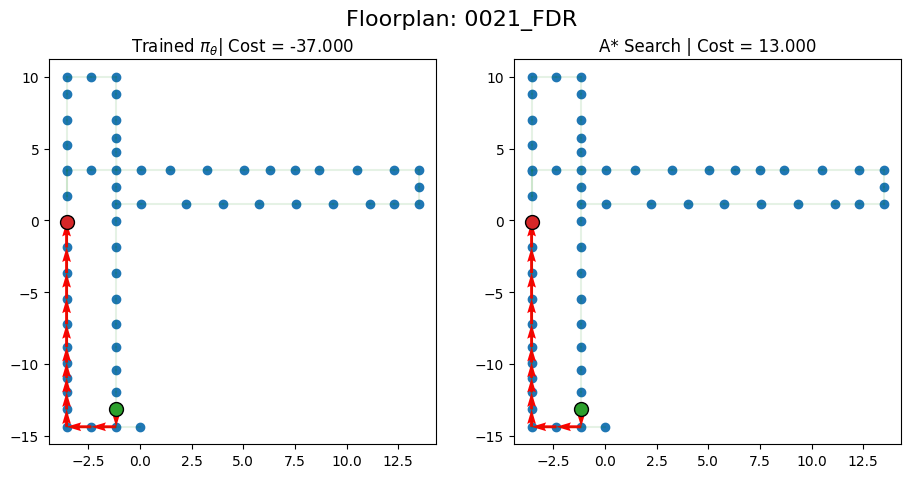

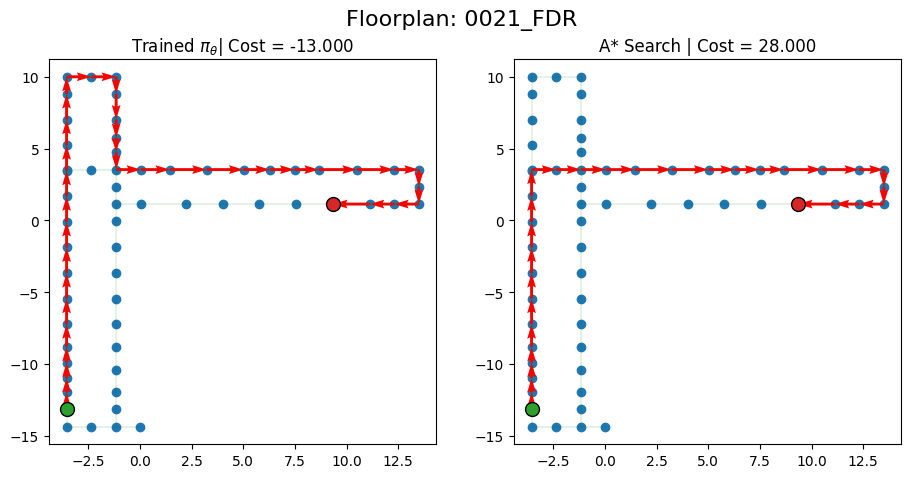

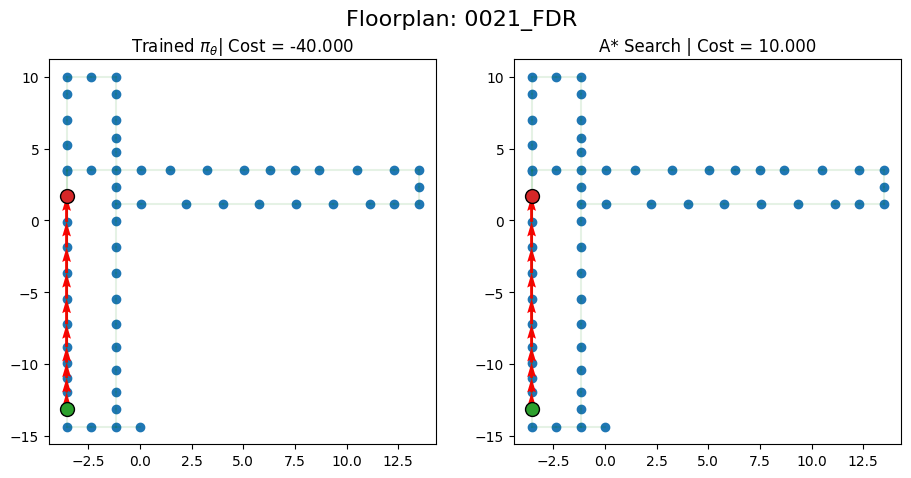

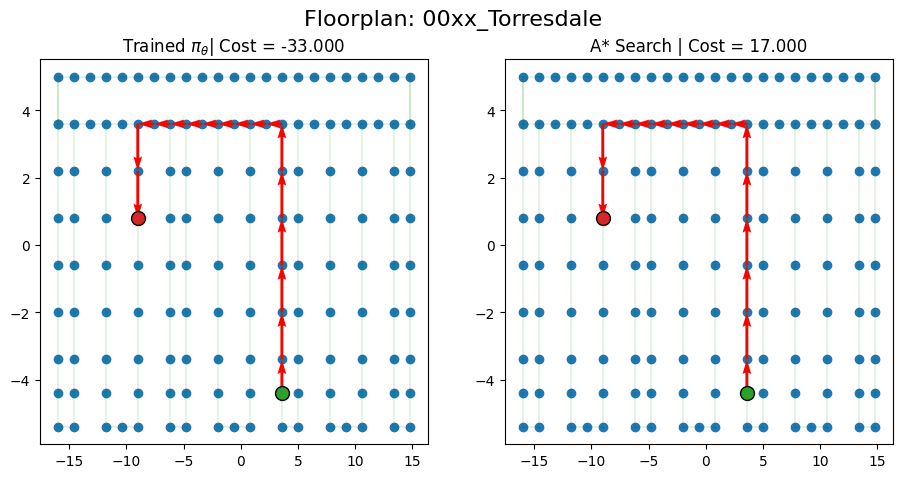

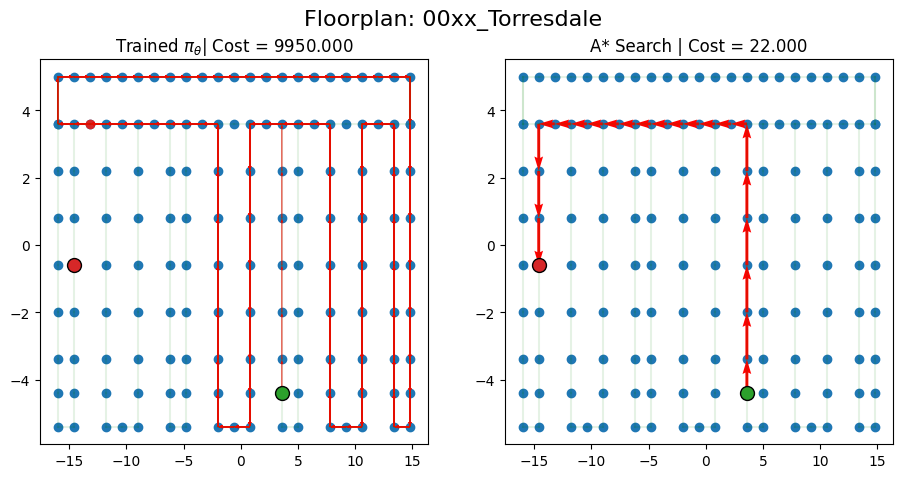

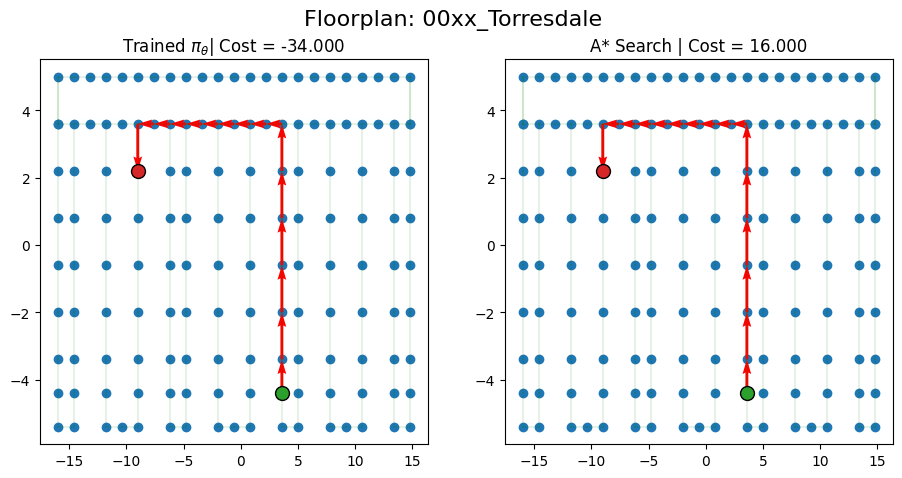

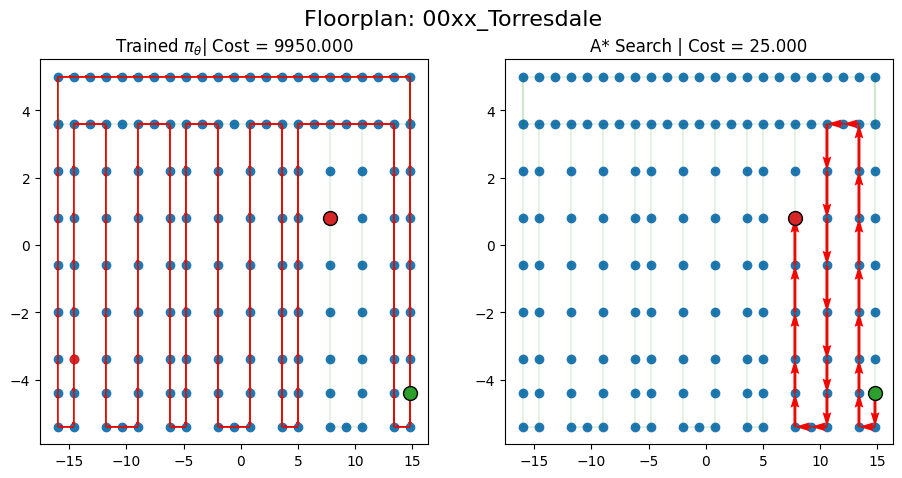

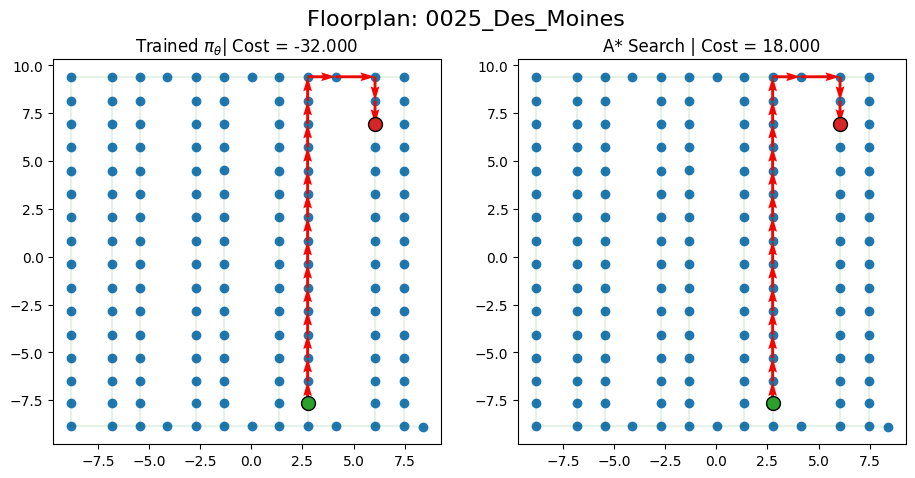

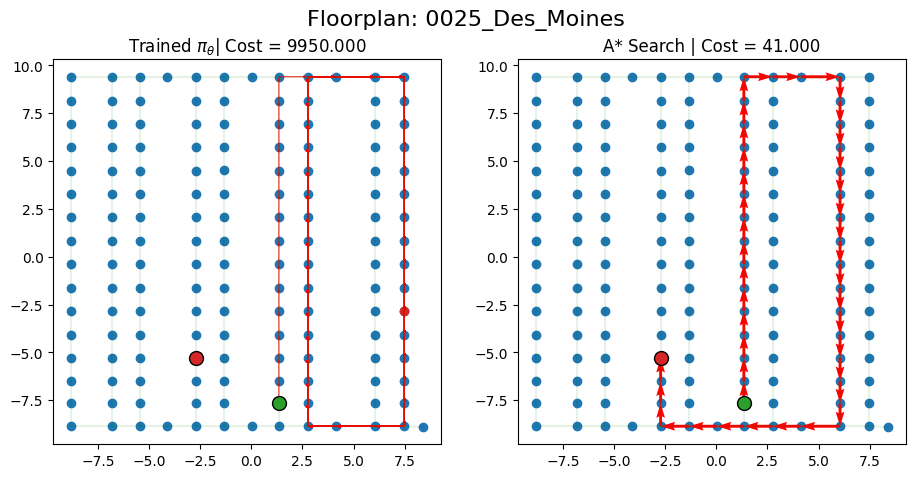

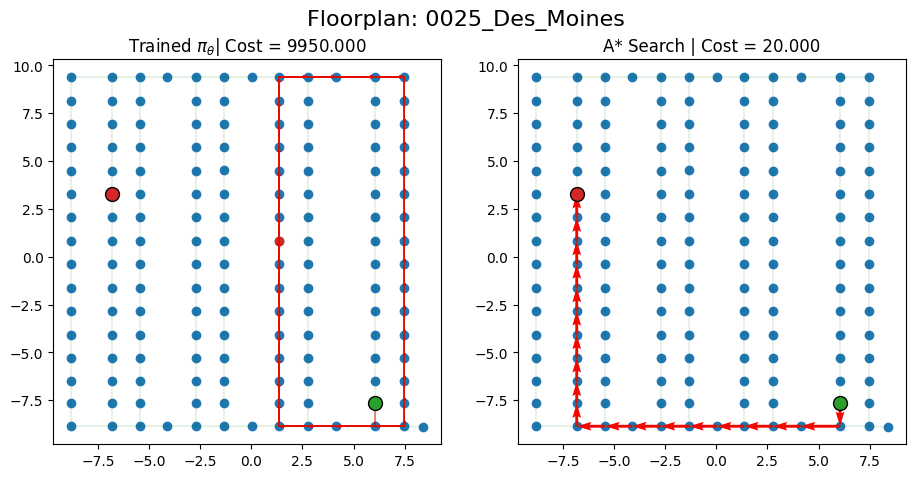

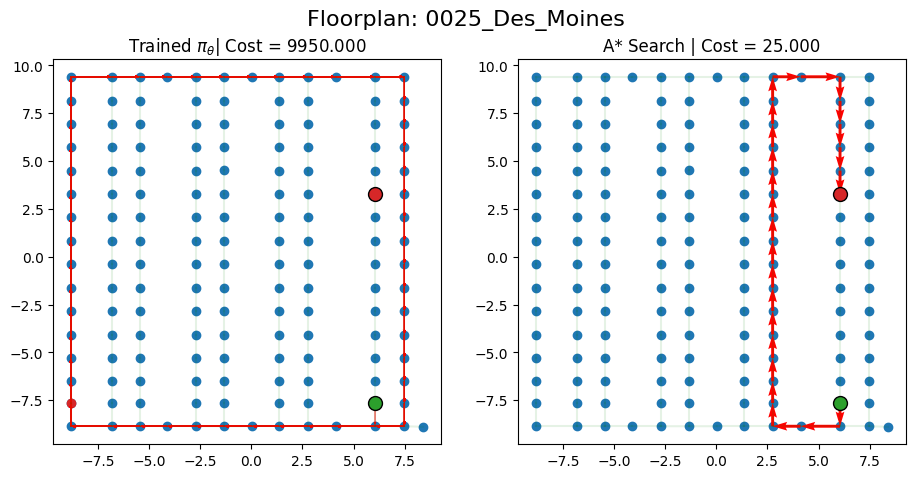

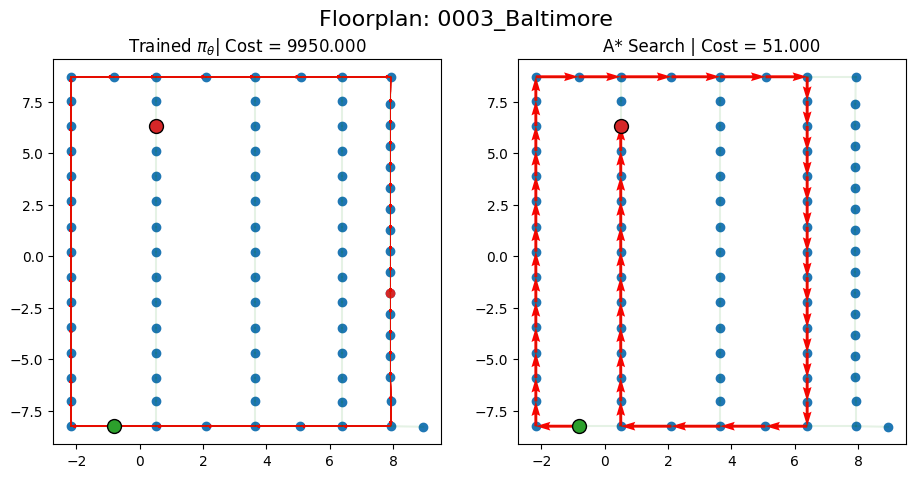

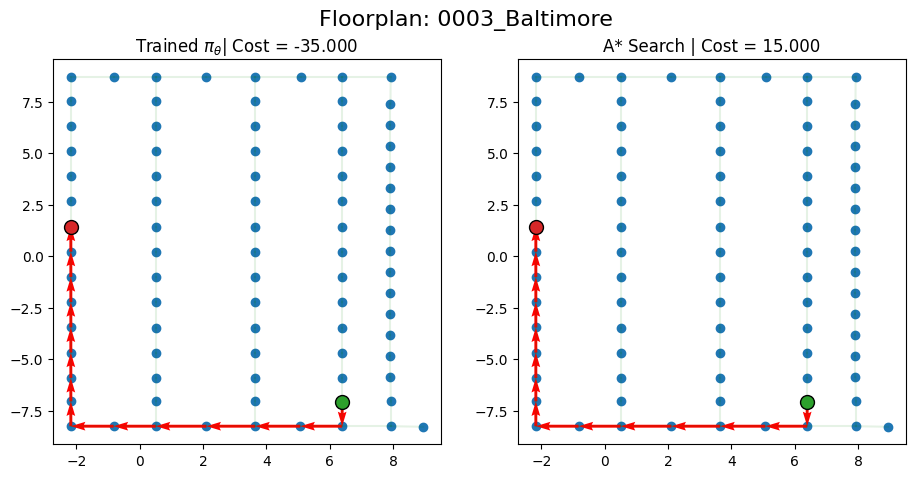

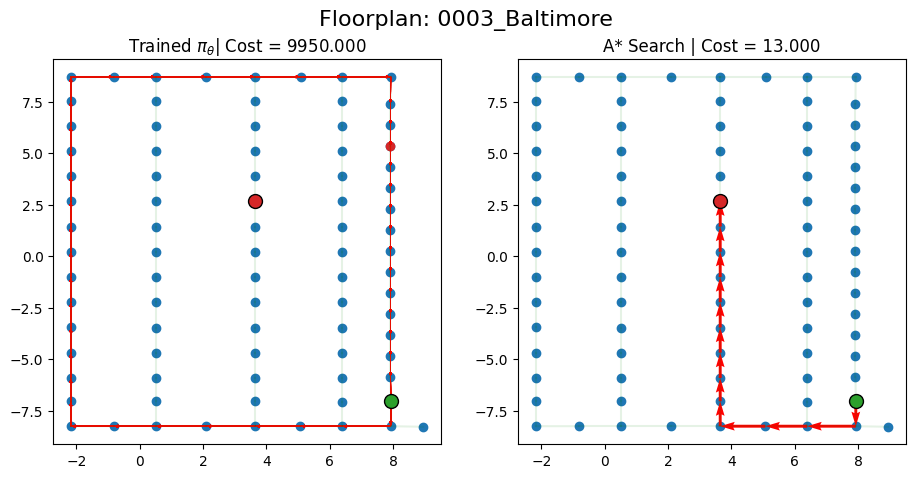

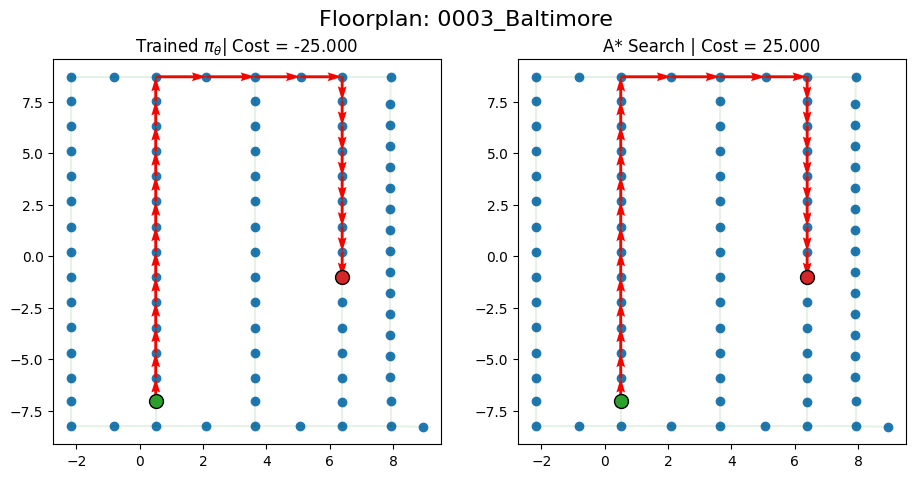

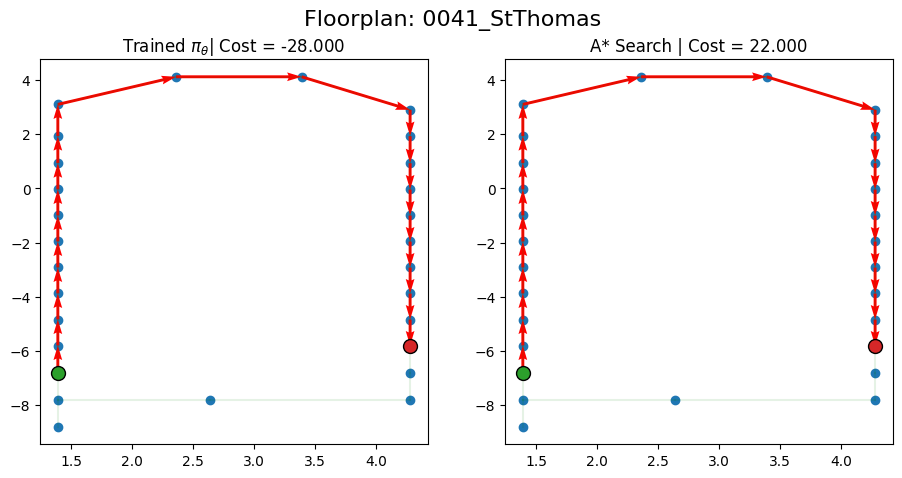

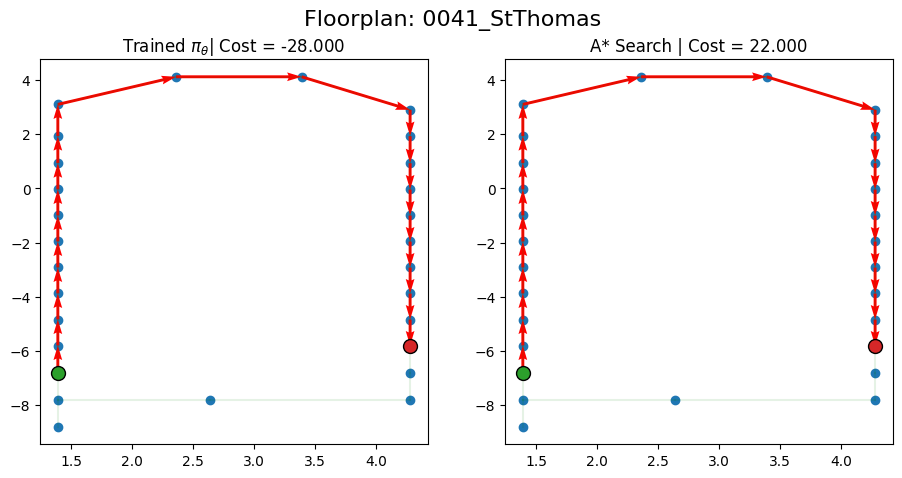

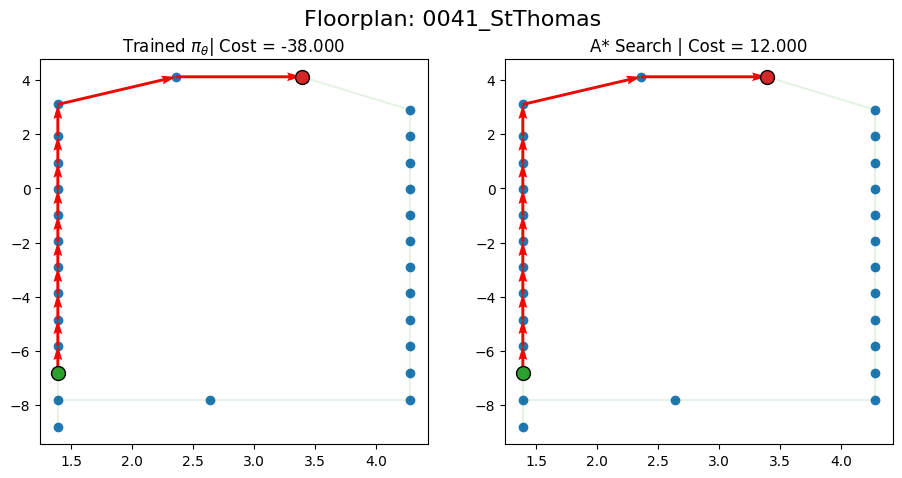

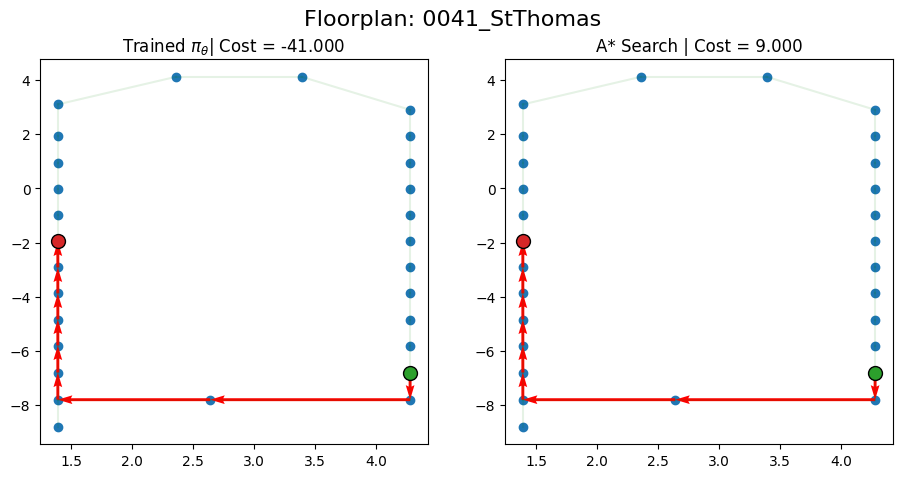

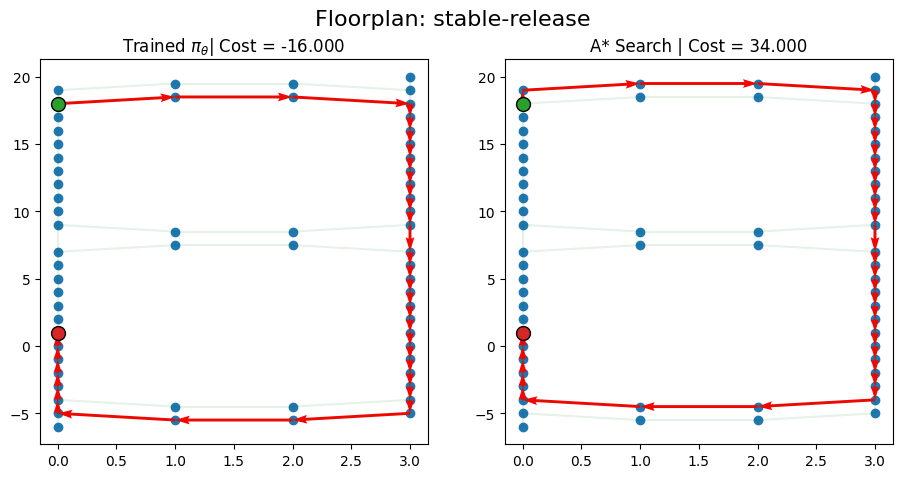

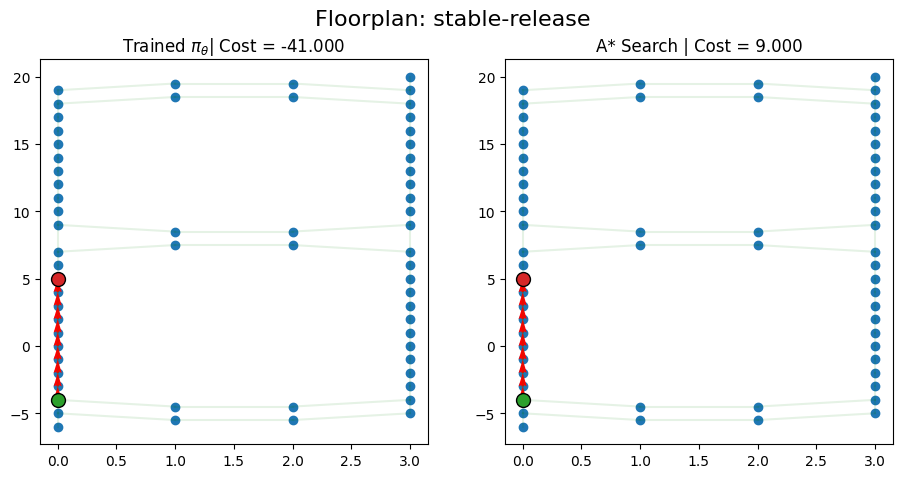

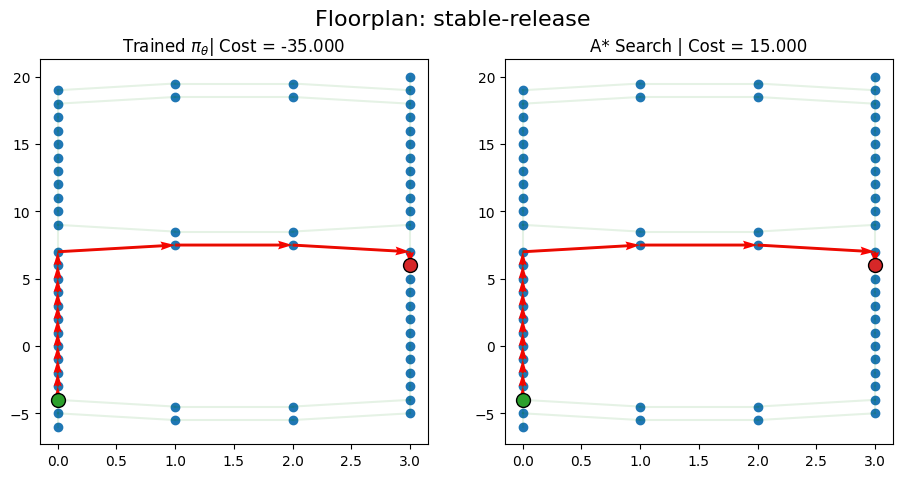

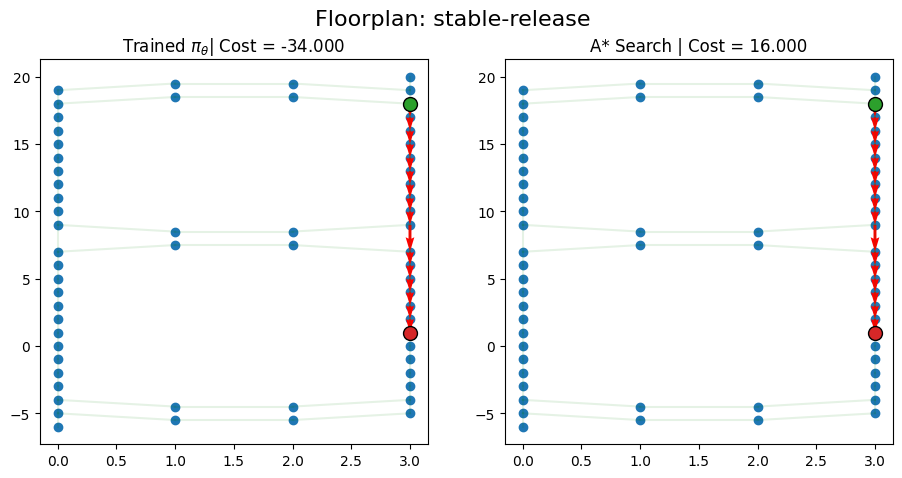

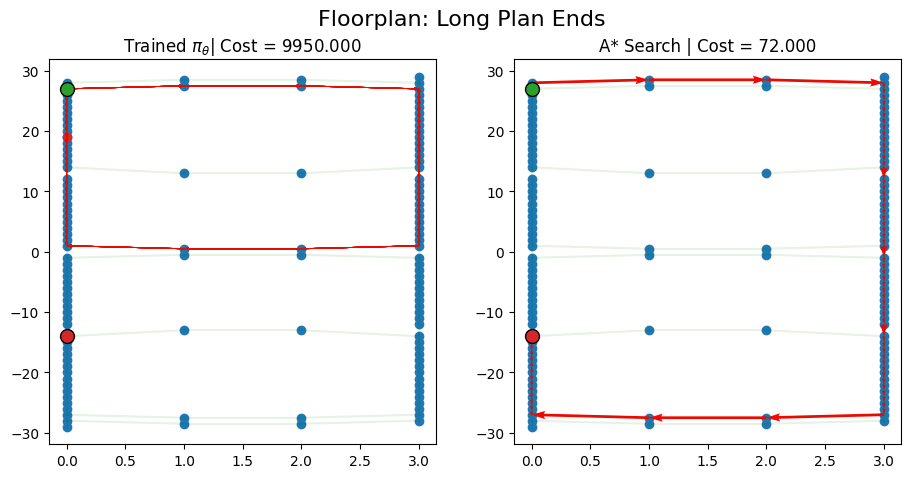

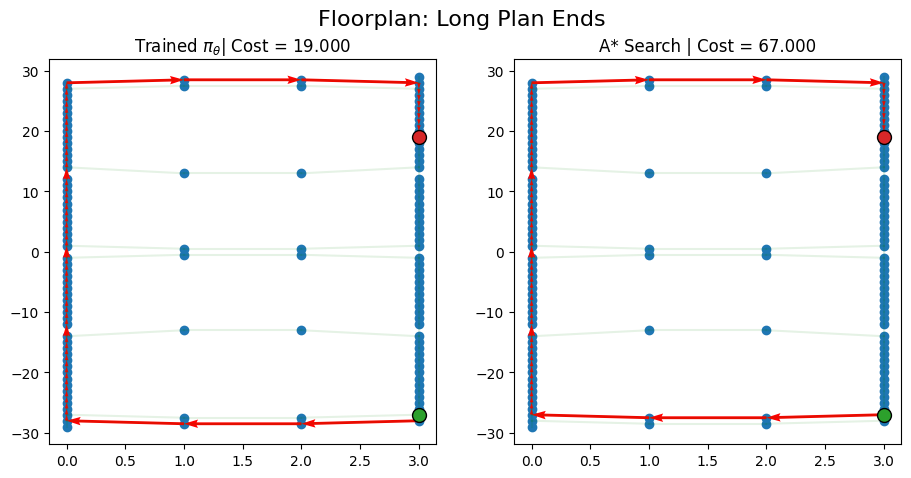

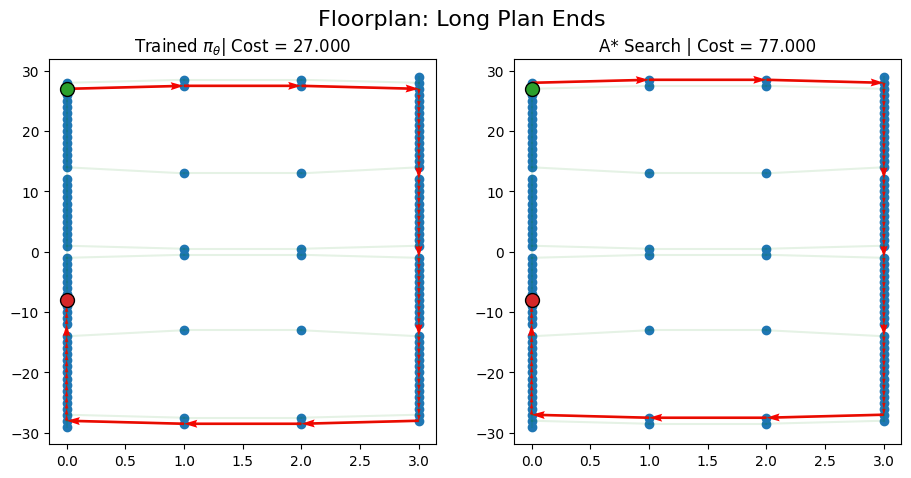

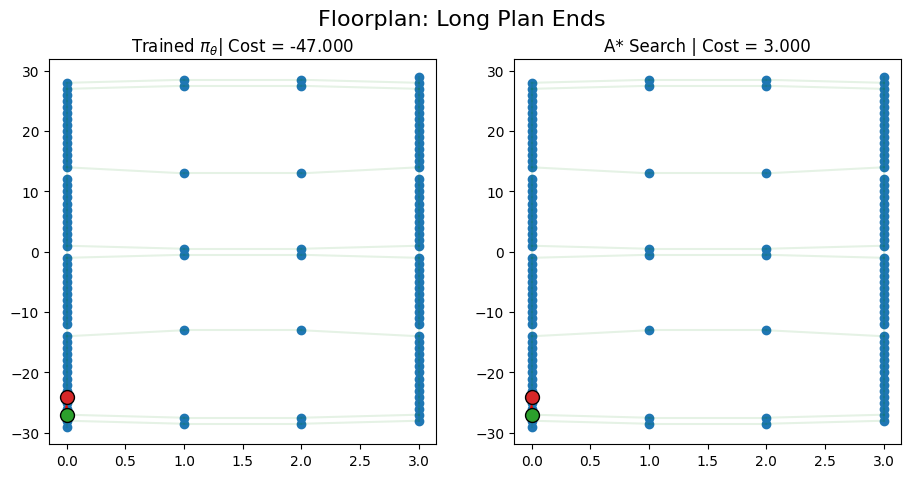

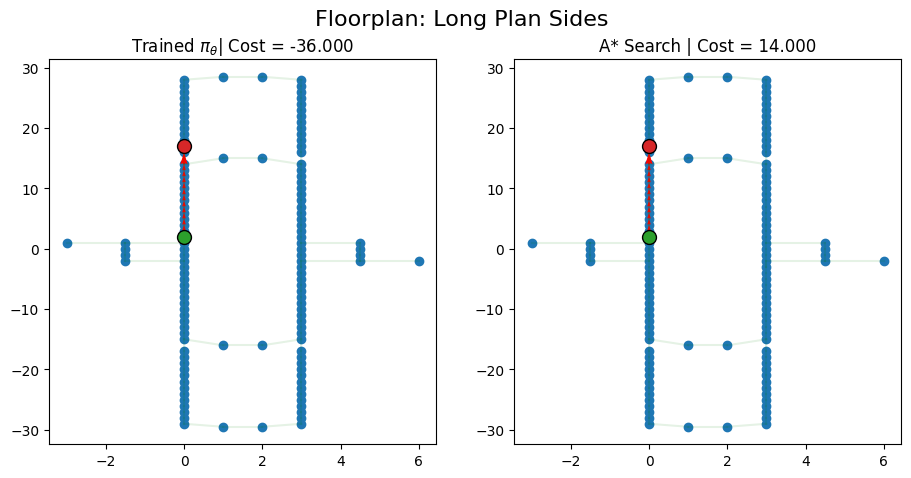

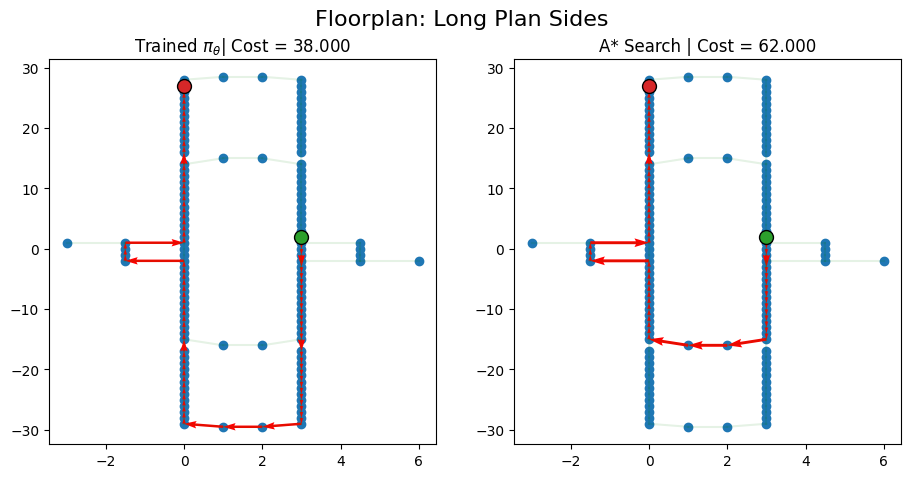

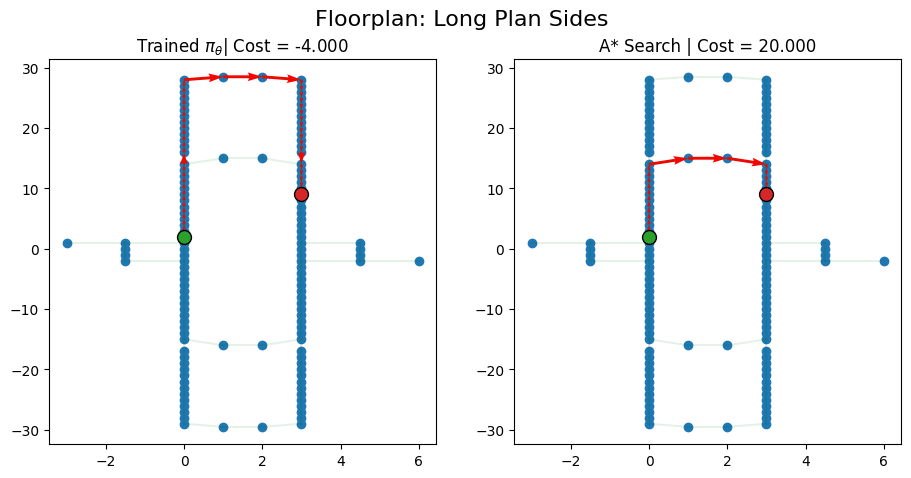

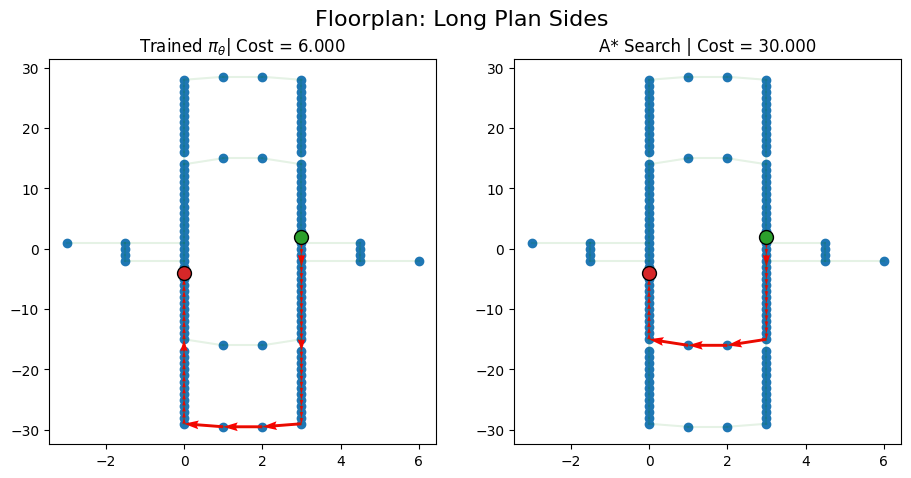

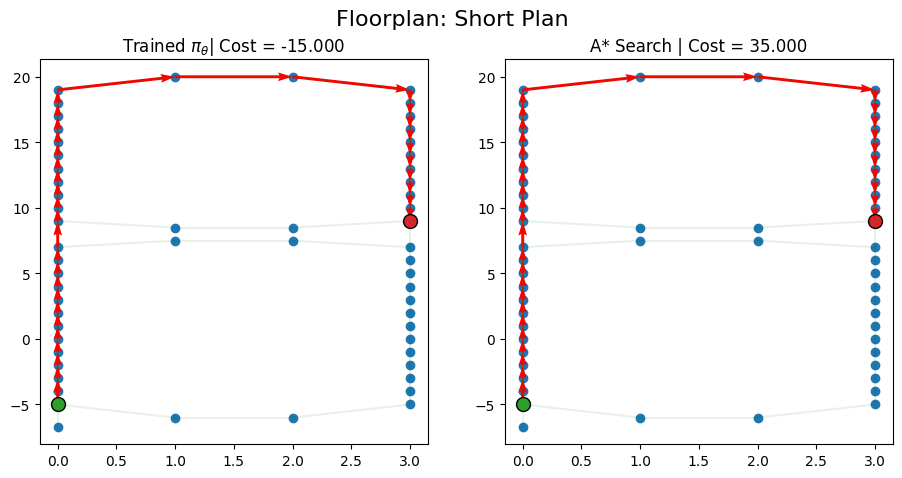

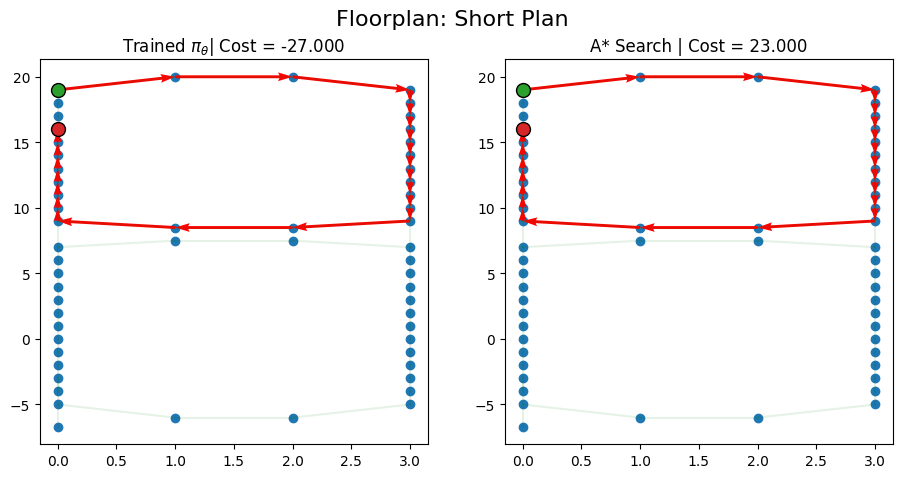

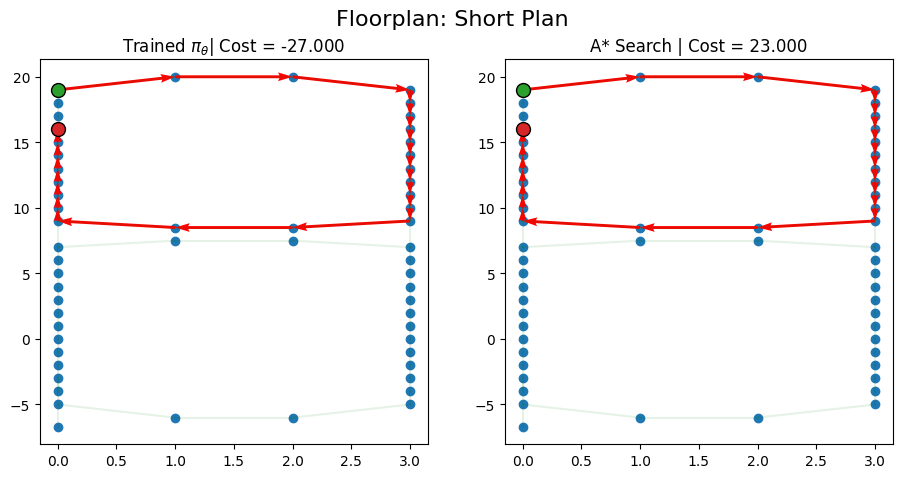

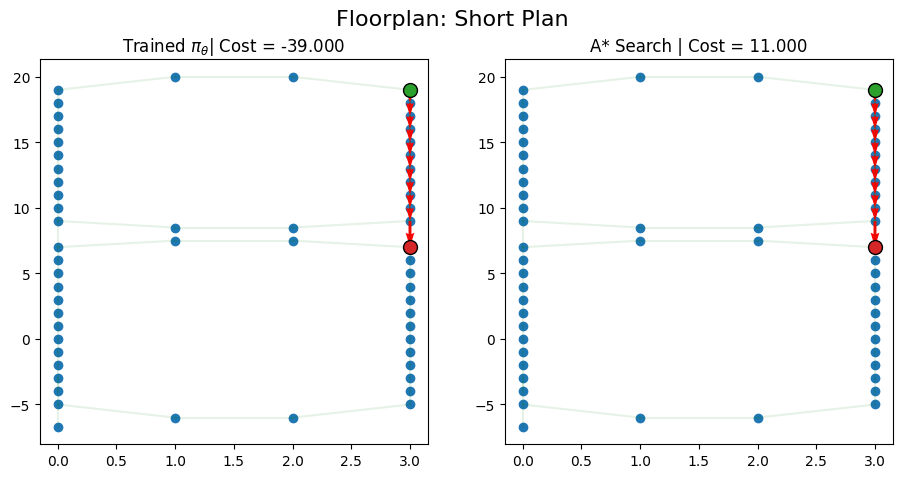

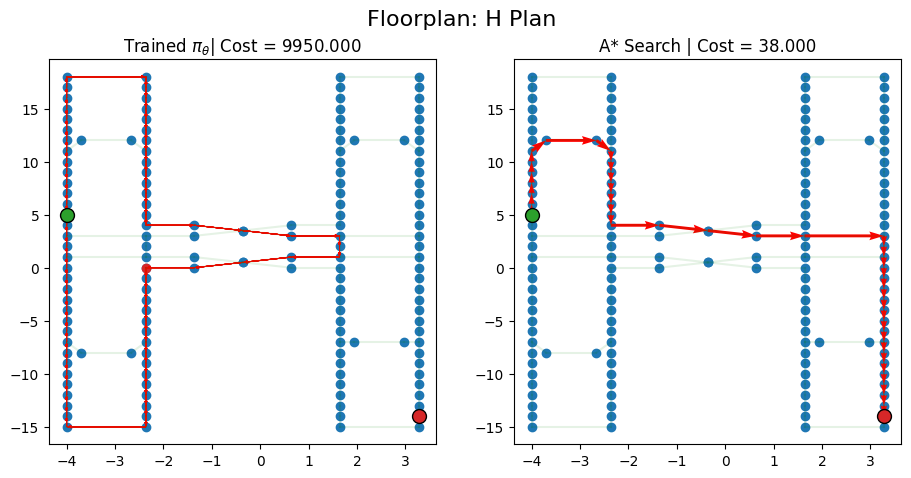

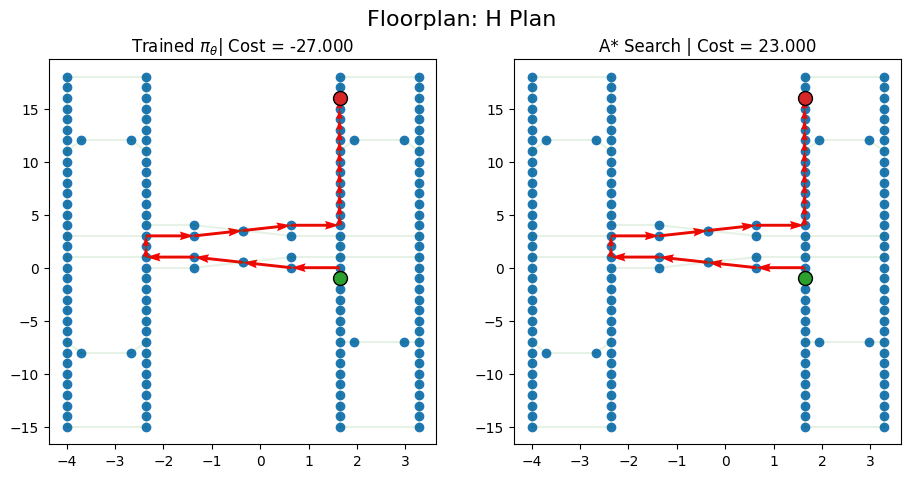

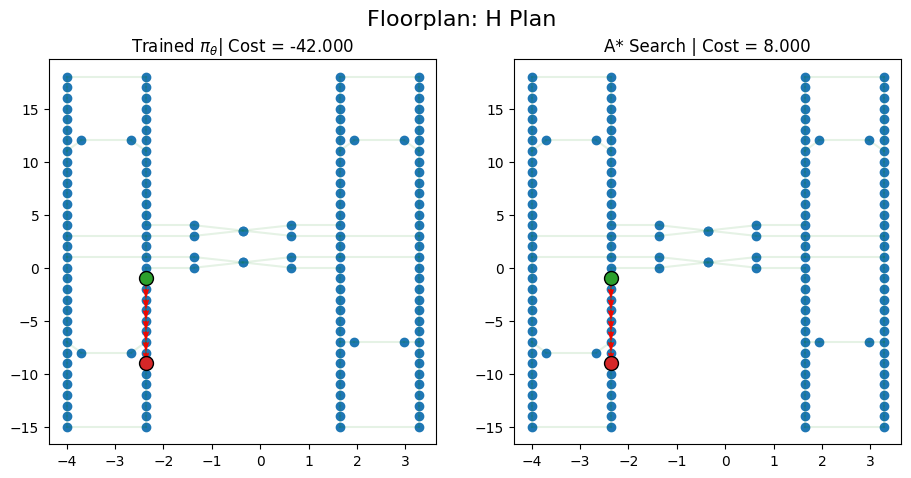

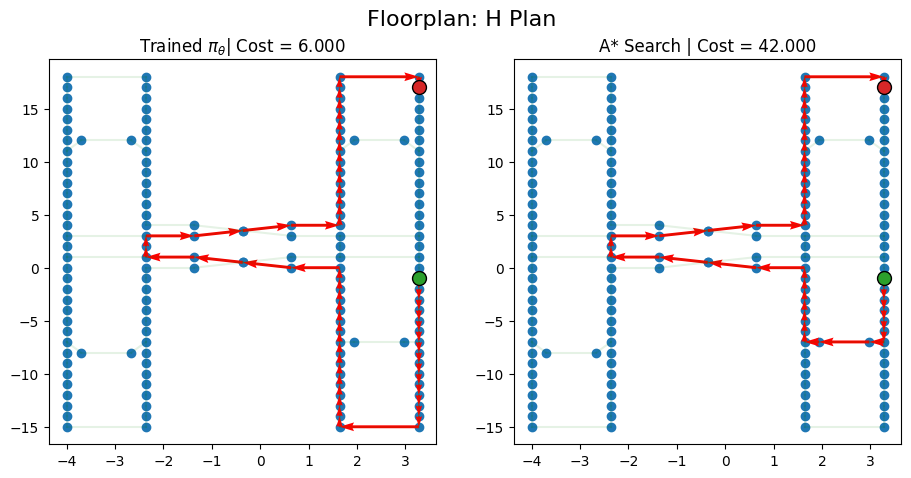

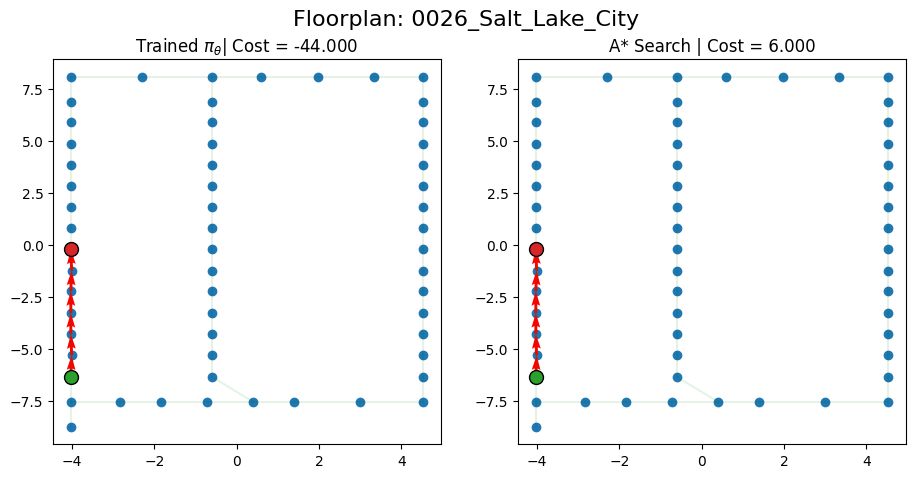

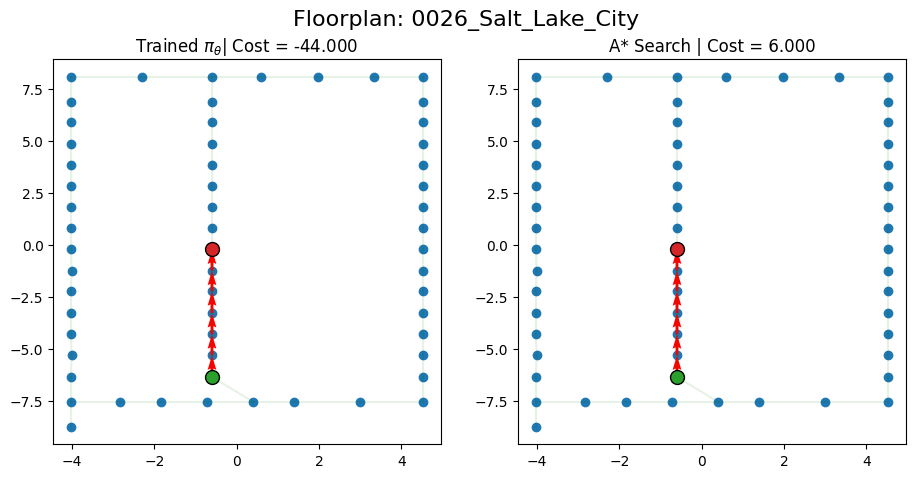

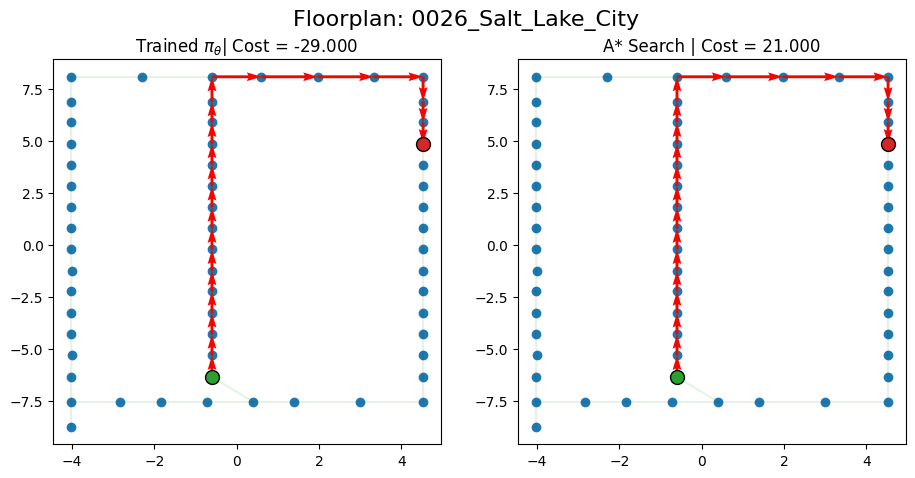

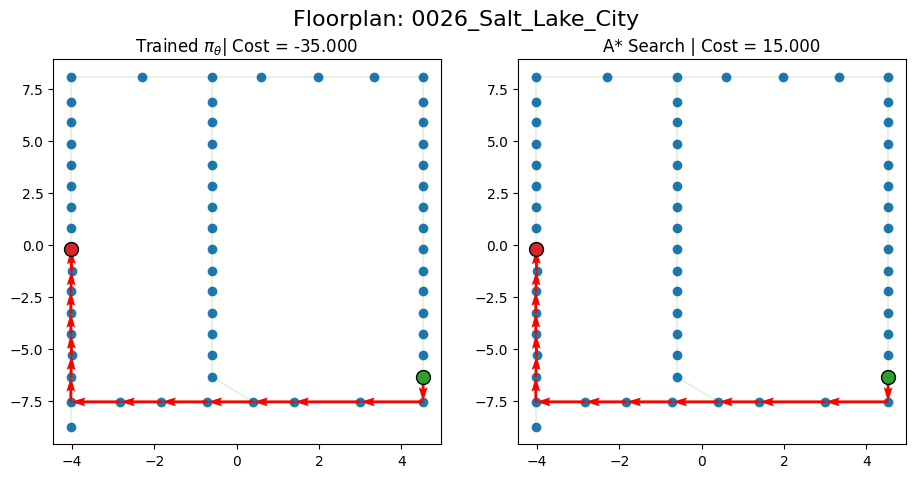

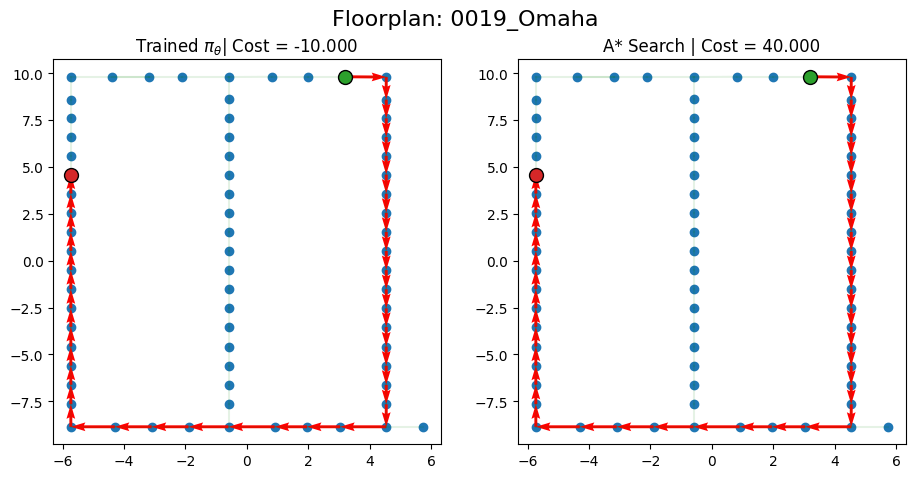

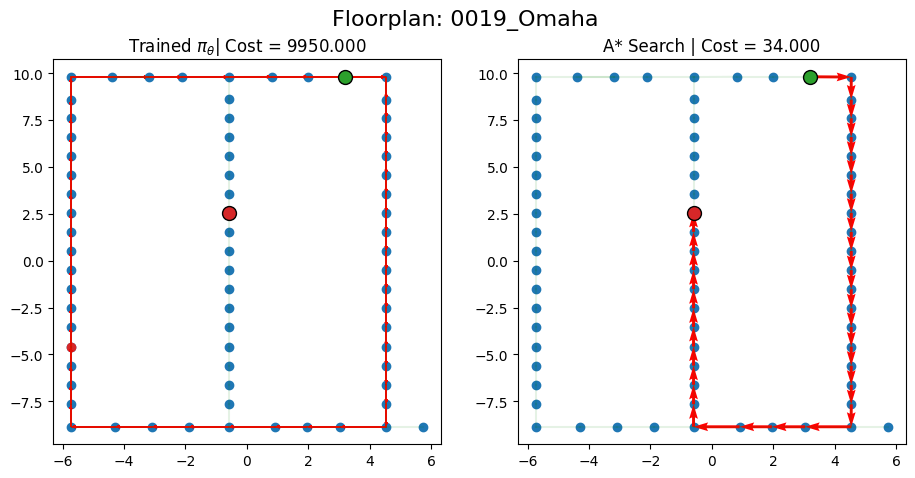

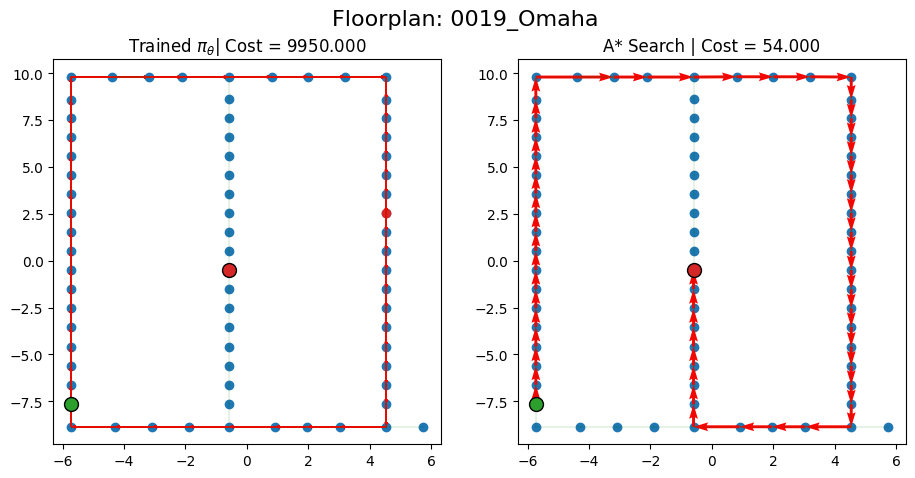

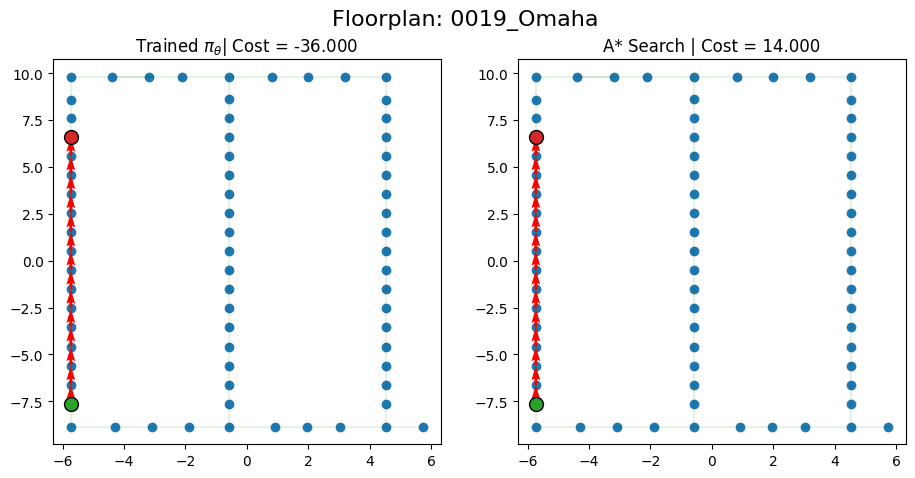

In [14]:
from FPenv import FPEnv
from astar import AStarSearch
from Floorplan_Codes.utils import get_paths
import torch

# Setup a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

floorplans = get_paths("floorplan.json", "Floorplans/USPS", recursive=True, depth=1)
ids = []
for floorplan in floorplans:
    try:
        infer_env = FPEnv(fp_path=floorplan)
        td_init = infer_env.reset(batch_size=[4]).to(device)


        # Function to check for NaNs in a tensor dictionary
        nan_found = False
        for key, tensor in td_init.items():
            if torch.isnan(tensor).any():
              nan_found = True
              print(f"NaN values found in tensor '{key}'")
        if not nan_found:
            print("No NaN values found in the tensor dictionary.")

        policy = model.policy.to(device)

        out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
        actions_trained = out['actions'].cpu().detach()

        # run A* search on the environment
        astar = AStarSearch(td_init.clone())
        astar_out = astar.search()
        actions_astar = astar_out["actions"].cpu().detach()

        # Plotting
        import matplotlib.pyplot as plt
        for i, td in enumerate(td_init):
            fig, axs = plt.subplots(1,2, figsize=(11,5))

            parts = floorplan.split('/')
            site = parts[-2]
            fig.suptitle("Floorplan: " + site, fontsize=16)

            infer_env.render(td, actions_trained[i], ax=axs[0])
            axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

            infer_env.render(td, actions_astar[i], ax=axs[1])
            axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))
    except Exception as e:
        print(e)
        continue
